# Model evaluation: response_var = perc_detected_10d

Create a base line, how good can we predict without deep-learning? Les create a base classifier using tpot out-of-the-box.

In [1]:
import sys
sys.path.append("../../") # go to parent dir
# from customFunctions import *

In [2]:
import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from tpot import TPOTRegressor
import pandas as pd
from sklearn.metrics import mean_squared_error
from plotnine import *
import plotnine as pltn
import joblib
import tensorflow as tf

from data.datasets import load_dataset, load_dataset
from modeling.eval import eval_model
from modeling.training import create_training_folder
from random import randrange
import matplotlib.pyplot as plt


# %matplotlib notebook
%matplotlib inline


/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
Using TensorFlow backend.


In [3]:
BASE_FOLDER = '/home/gus/workspaces/wpy/roya/results'

def load_model(exp_folder):
    path = os.path.join(BASE_FOLDER, exp_folder)
    model_path = os.path.join(path, "model.joblib")
    model = joblib.load(model_path)

    return model

def load_scaler(exp_folder):
    path = os.path.join(BASE_FOLDER, exp_folder)
    scaler_path = os.path.join(path, "scaler.joblib")
    return joblib.load(scaler_path)


In [4]:
    

cols = ['temp_min', 'temp_max', 'temp_mean', 'temp_median', 'temp_std',
                      'prec_min', 'prec_max', 'prec_mean', 'prec_median', 'prec_std',
                      'hum_min', 'hum_max', 'hum_mean', 'hum_median', 'hum_std',
                      # 'wdir_min', 'wdir_max', 'wdir_mean', 'wdir_median', 'wdir_std',
                      'wspeed_min', 'wspeed_max', 'wspeed_mean', 'wspeed_median', 'wspeed_std',
                      'radiation_min', 'radiation_max', 'radiation_mean', 'radiation_median', 'radiation_std',
                      'prec_10d', 'prec_30d', 'prec_60d',
                      'temp_int_4_30',
                      'roya_event_skip_10d',  # 'roya_event_10d',
                      'prec_expected_30d', 'prec_exp_perc_30d',  # 'prec_exp_sgm_30d',
                      'prec_expected_60d', 'prec_exp_perc_60d',  # 'prec_exp_sgm_60d',
                      'dyear_sin', 'dyear_cos',
                      'roya_perc_event_skip_10d',
                      'altitud',
                      # 'perc_detected_10d_t1', 'perc_detected_10d_t3', 'perc_detected_10d_t10'
                      ]

models = [
    ("xgb",
        cols, 
     load_model('xgboost/20201222_090208_perc_detected_10d_noAutoR'),
     load_scaler('xgboost/20201222_090208_perc_detected_10d_noAutoR'),
    ),
     ("xgb-AutoR",
    cols + ['perc_detected_10d_t1', 'perc_detected_10d_t3', 'perc_detected_10d_t10'], 
     load_model('xgboost/20201222_090310_perc_detected_10d_AutoR'),
     load_scaler('xgboost/20201222_090310_perc_detected_10d_AutoR'),
    ) 
]


(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_dataset(response_var="perc_detected_10d")

In [5]:
print(X_train.shape)

print(X_test.shape)

print(X_val.shape)


(10647, 66)
(3549, 66)
(1153, 66)


In [6]:
print(y_test.describe())
print(y_val.describe())

count    3549.000000
mean        0.046590
std         0.156905
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: perc_detected_10d, dtype: float64
count    1153.000000
mean        0.060176
std         0.168648
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: perc_detected_10d, dtype: float64


In [7]:
# scaler.transform(X_val[cols].values)

# for each model calculate its predictions and attach to X_val dataset
X_val["gtrue"] = y_val
for r in models:
    name, cols, model, scaler = r
    X_val["pred_"+name] = model.predict(scaler.transform(X_val[cols]))
    X_val["rss_"+name] = np.square(X_val["gtrue"] - X_val["pred_"+name])

In [8]:
X_val.columns

Index(['idest', 'date', 'temp_min', 'temp_max', 'temp_mean', 'temp_median',
       'temp_std', 'prec_min', 'prec_max', 'prec_mean', 'prec_median',
       'prec_std', 'hum_min', 'hum_max', 'hum_mean', 'hum_median', 'hum_std',
       'wdir_min', 'wdir_max', 'wdir_mean', 'wdir_median', 'wdir_std',
       'wspeed_min', 'wspeed_max', 'wspeed_mean', 'wspeed_median',
       'wspeed_std', 'radiation_min', 'radiation_max', 'radiation_mean',
       'radiation_median', 'radiation_std', 'prec_10d', 'prec_30d', 'prec_60d',
       'temp_int_4_30', 'prec_expected_30d', 'prec_expected_60d',
       'roya_event_10d', 'roya_event_skip_10d', 'prec_exp_perc_30d',
       'prec_exp_perc_60d', 'prec_exp_sgm_30d', 'prec_exp_sgm_60d', 'year',
       'month', 'month_sin', 'month_cos', 'week', 'week_sin', 'week_cos',
       'dyear', 'dyear_sin', 'dyear_cos', 'roya_perc_event_skip_10d',
       'roya_perc_event_10d', 'detected_10d', 'n_um_10d', 'altitud',
       'altitud_est', 'n_um', 'detected', 'perc_detected',
 

# Plot model predictions
Predictions on validation dataset


In [76]:
# plt.figure(figsize=(60,40), dpi= 100, facecolor='w', edgecolor='k')
# pltn.options.figure_size = (30, 10)

(ggplot(X_val)
 + aes(x='dyear')
 +geom_jitter(aes(y='gtrue'),color="green", size = 1.5, alpha=0.5)
 +geom_jitter(aes(y='pred_xgb'),color='brown', alpha=0.5)
#  +geom_jitter(aes(y='pred_xgb-AutoR'),color='blue', alpha=0.5)
 +facet_grid("idest~ year")
 +theme(figure_size=(30, 15))

 
 #   + scale_y_reverse()
#  +scale_colour_manual(name = 'the colour', values ={'brown':'brown','blue':'blue'}, labels = ['xgb','xgb-AutoR']) 
#  +theme_matplotlib(rc={"figure.figsize": "20, 20"})
)

# (ggplot(df,aes(idest))
# +geom_bar(aes(weight=n_um))+ coord_flip()+facet_grid(.~year) + labs(y = "Núm ud. muestrales", x="weather station") +theme_bw()


<ggplot: (8791576032888)>

## Residuos al cuadrado por estación y año (real vs predicción)

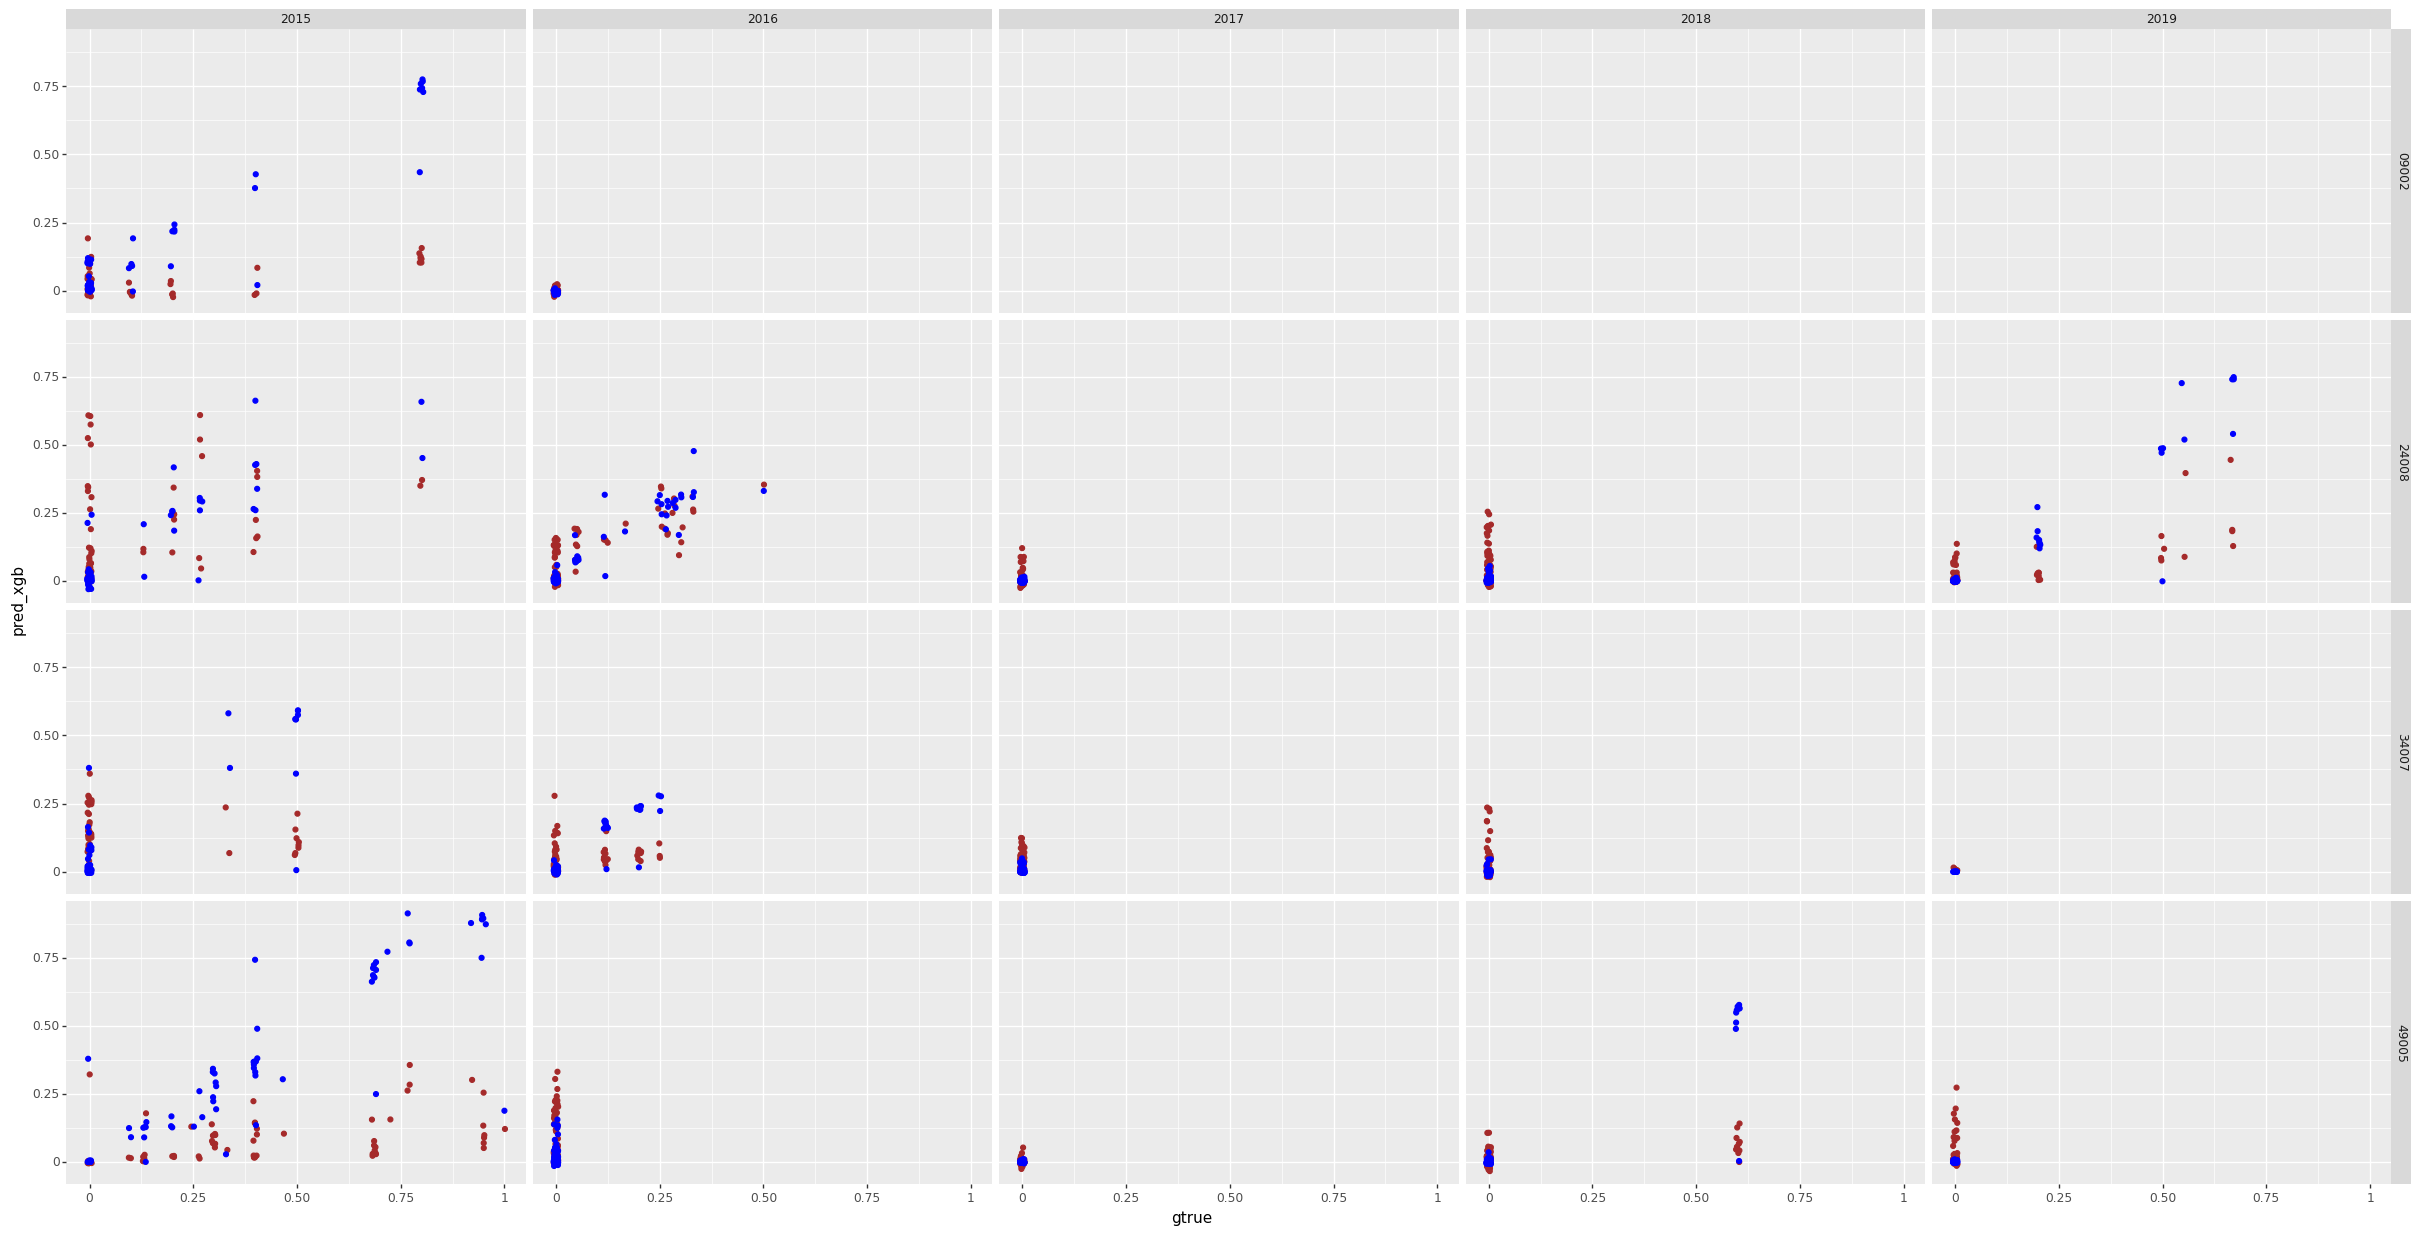

<ggplot: (8791637529313)>

In [49]:
(ggplot(X_val, aes(x='gtrue'))
 +geom_jitter(aes(y='pred_xgb'),color='brown')
 +geom_jitter(aes(y='pred_xgb-AutoR'),color='blue')
 
 +facet_grid("idest~ year")
 +theme(figure_size=(30, 15))
#  +theme_matplotlib(rc={"figure.figsize": "20, 20"})
)

**Predictions on test dataset**

In [ ]:


# calcular provincia para mostrar resultados por provincia



In [56]:
X_test["prov"] = X_test.idest.astype("string").str.pad(5,"left").str.slice(0,2)
print(X_test["prov"].unique())
X_test["pred"] = model.predict(scaler.transform(X_test[cols]))
X_test["gtrue"] = y_test

X_test["gtrue"] = y_test
for r in models:
    name, cols, model, scaler = r
    X_test["pred_"+name] = model.predict(scaler.transform(X_test[cols]))
    X_test["rss_"+name] = np.square(X_test["gtrue"] - X_test["pred_"+name])

<StringArray>
['47', '42', '09', '49', '40', '24', '34', '05', '37']
Length: 9, dtype: string


## Predicciones por provincia

Provincia 34


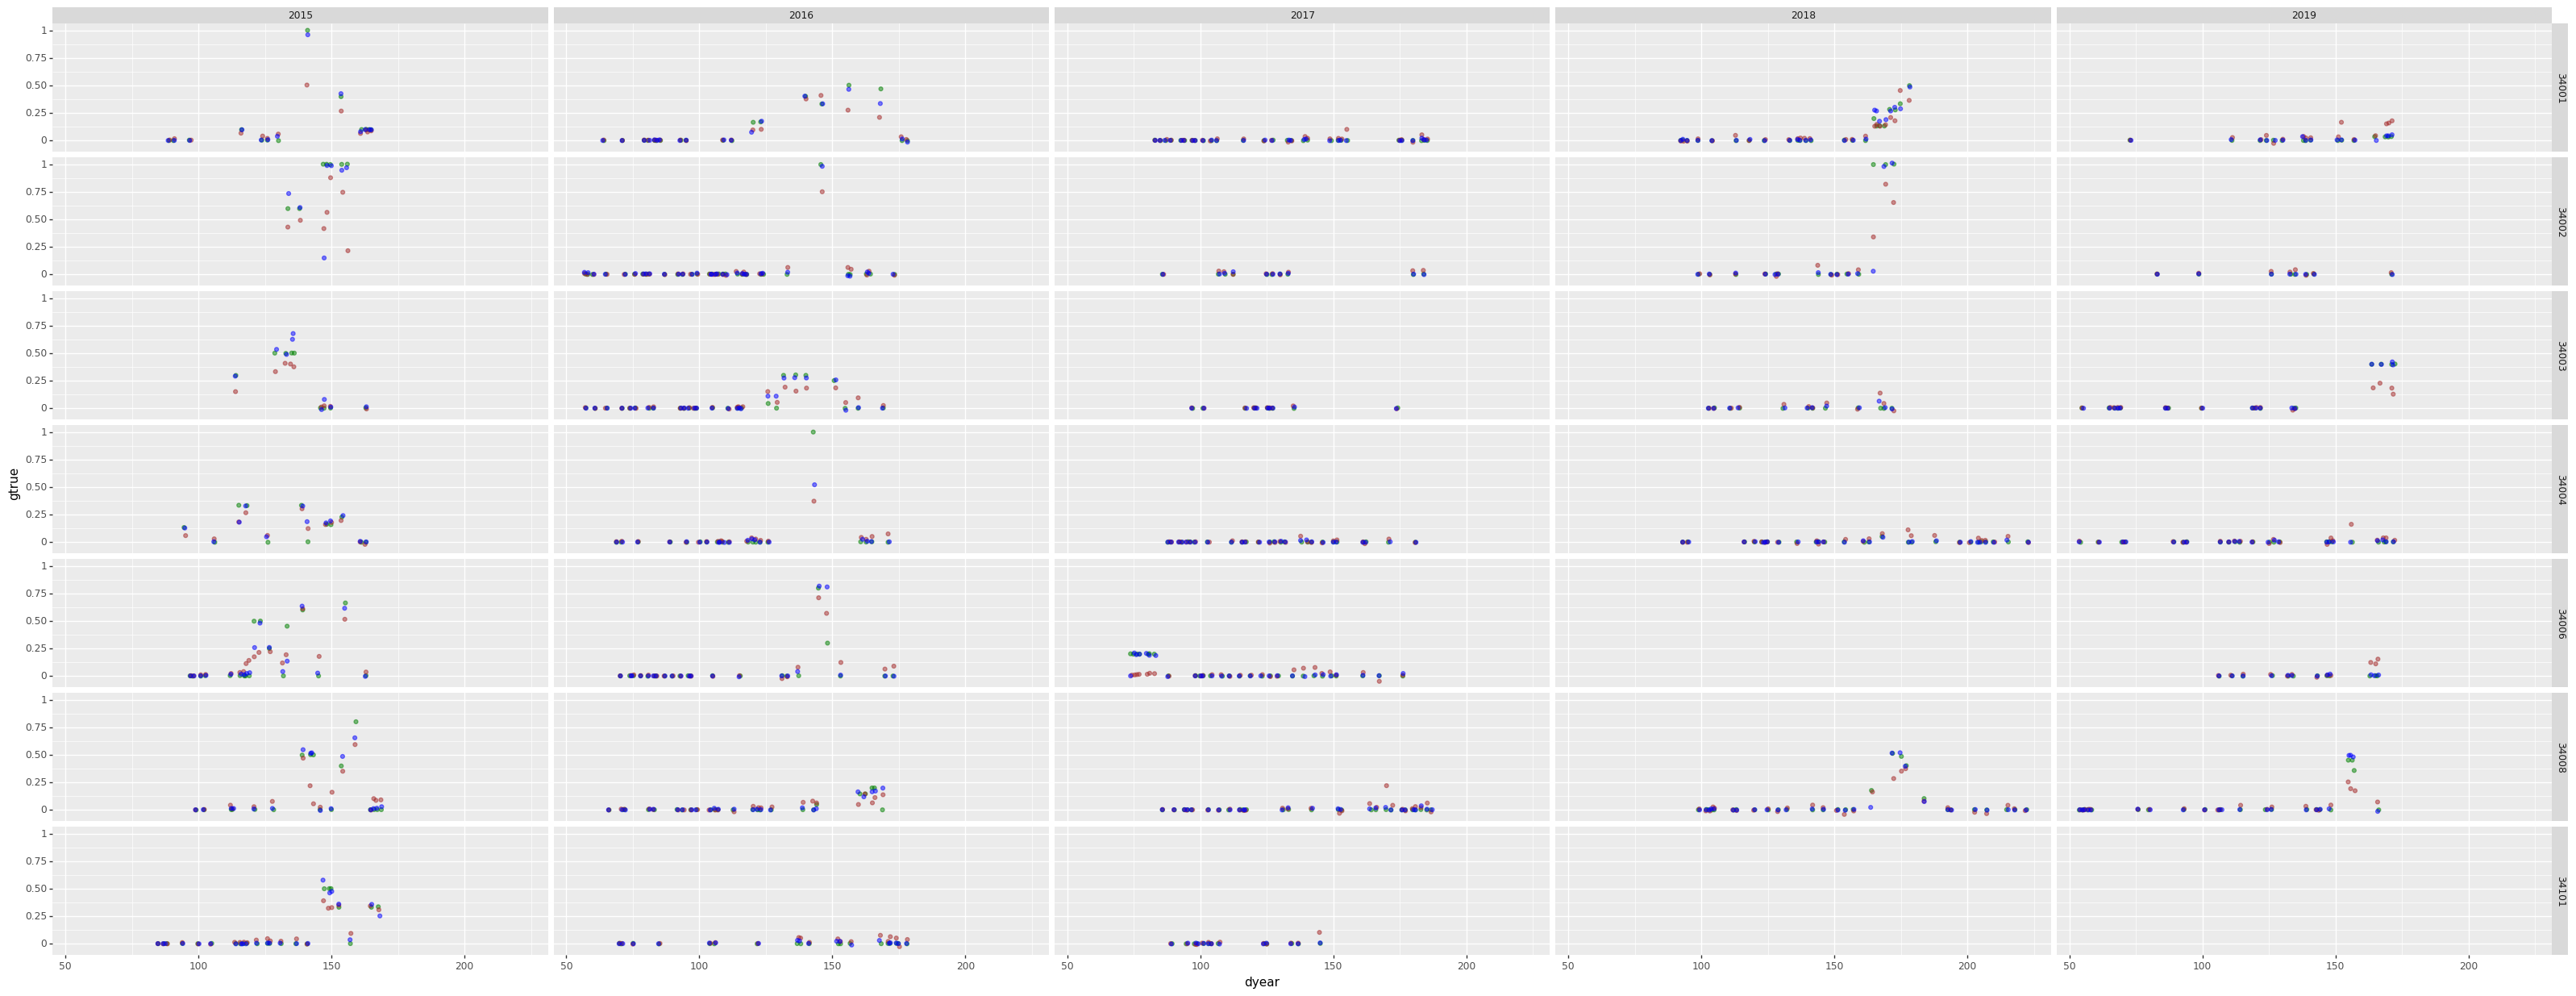

<ggplot: (-9223363245218283029)>
Provincia 49


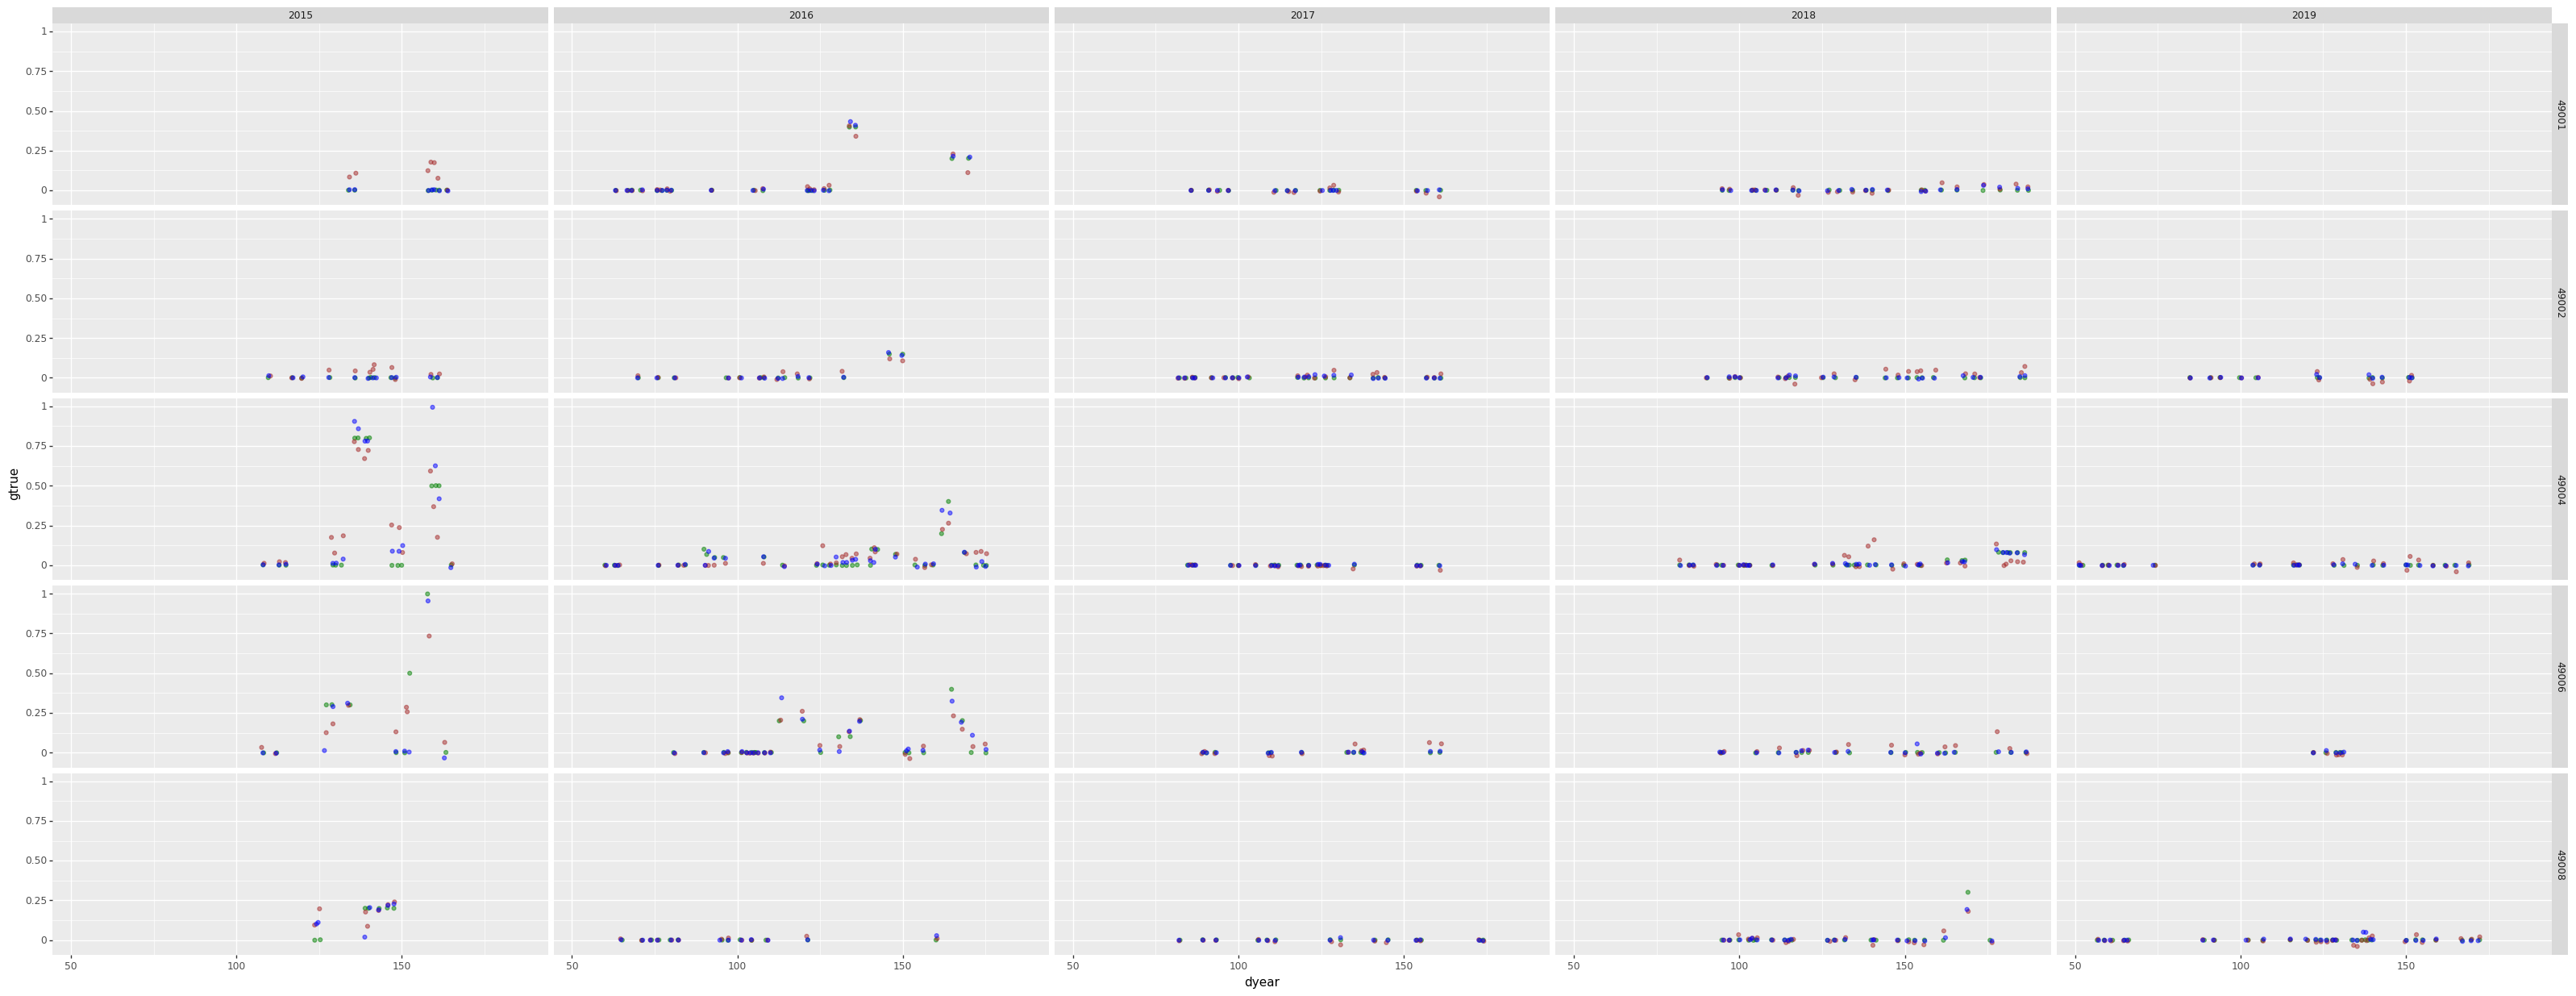

<ggplot: (-9223363245278986408)>
Provincia 24


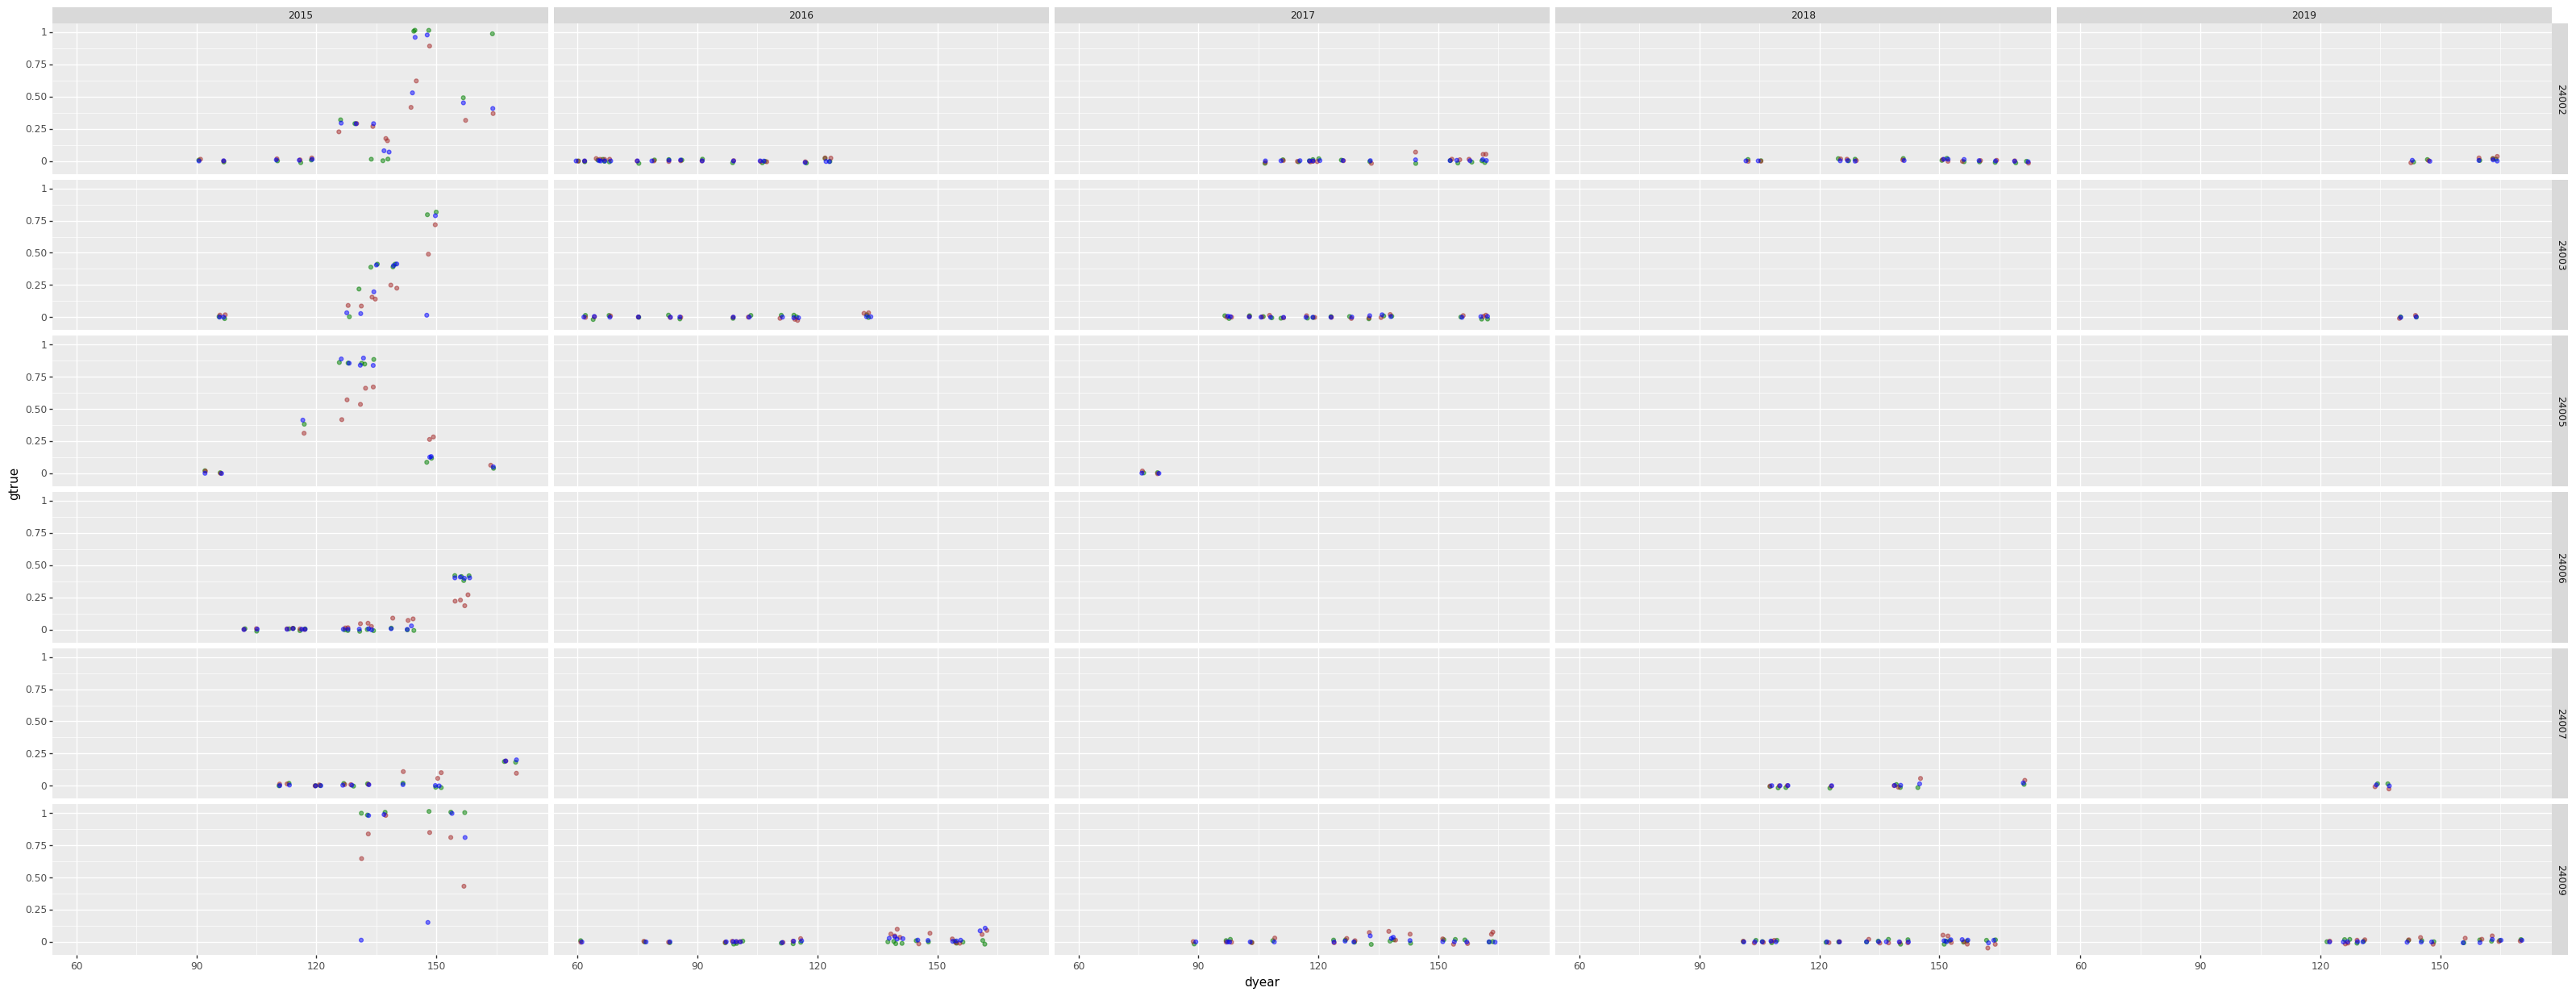

<ggplot: (-9223363245283362195)>
Provincia 47


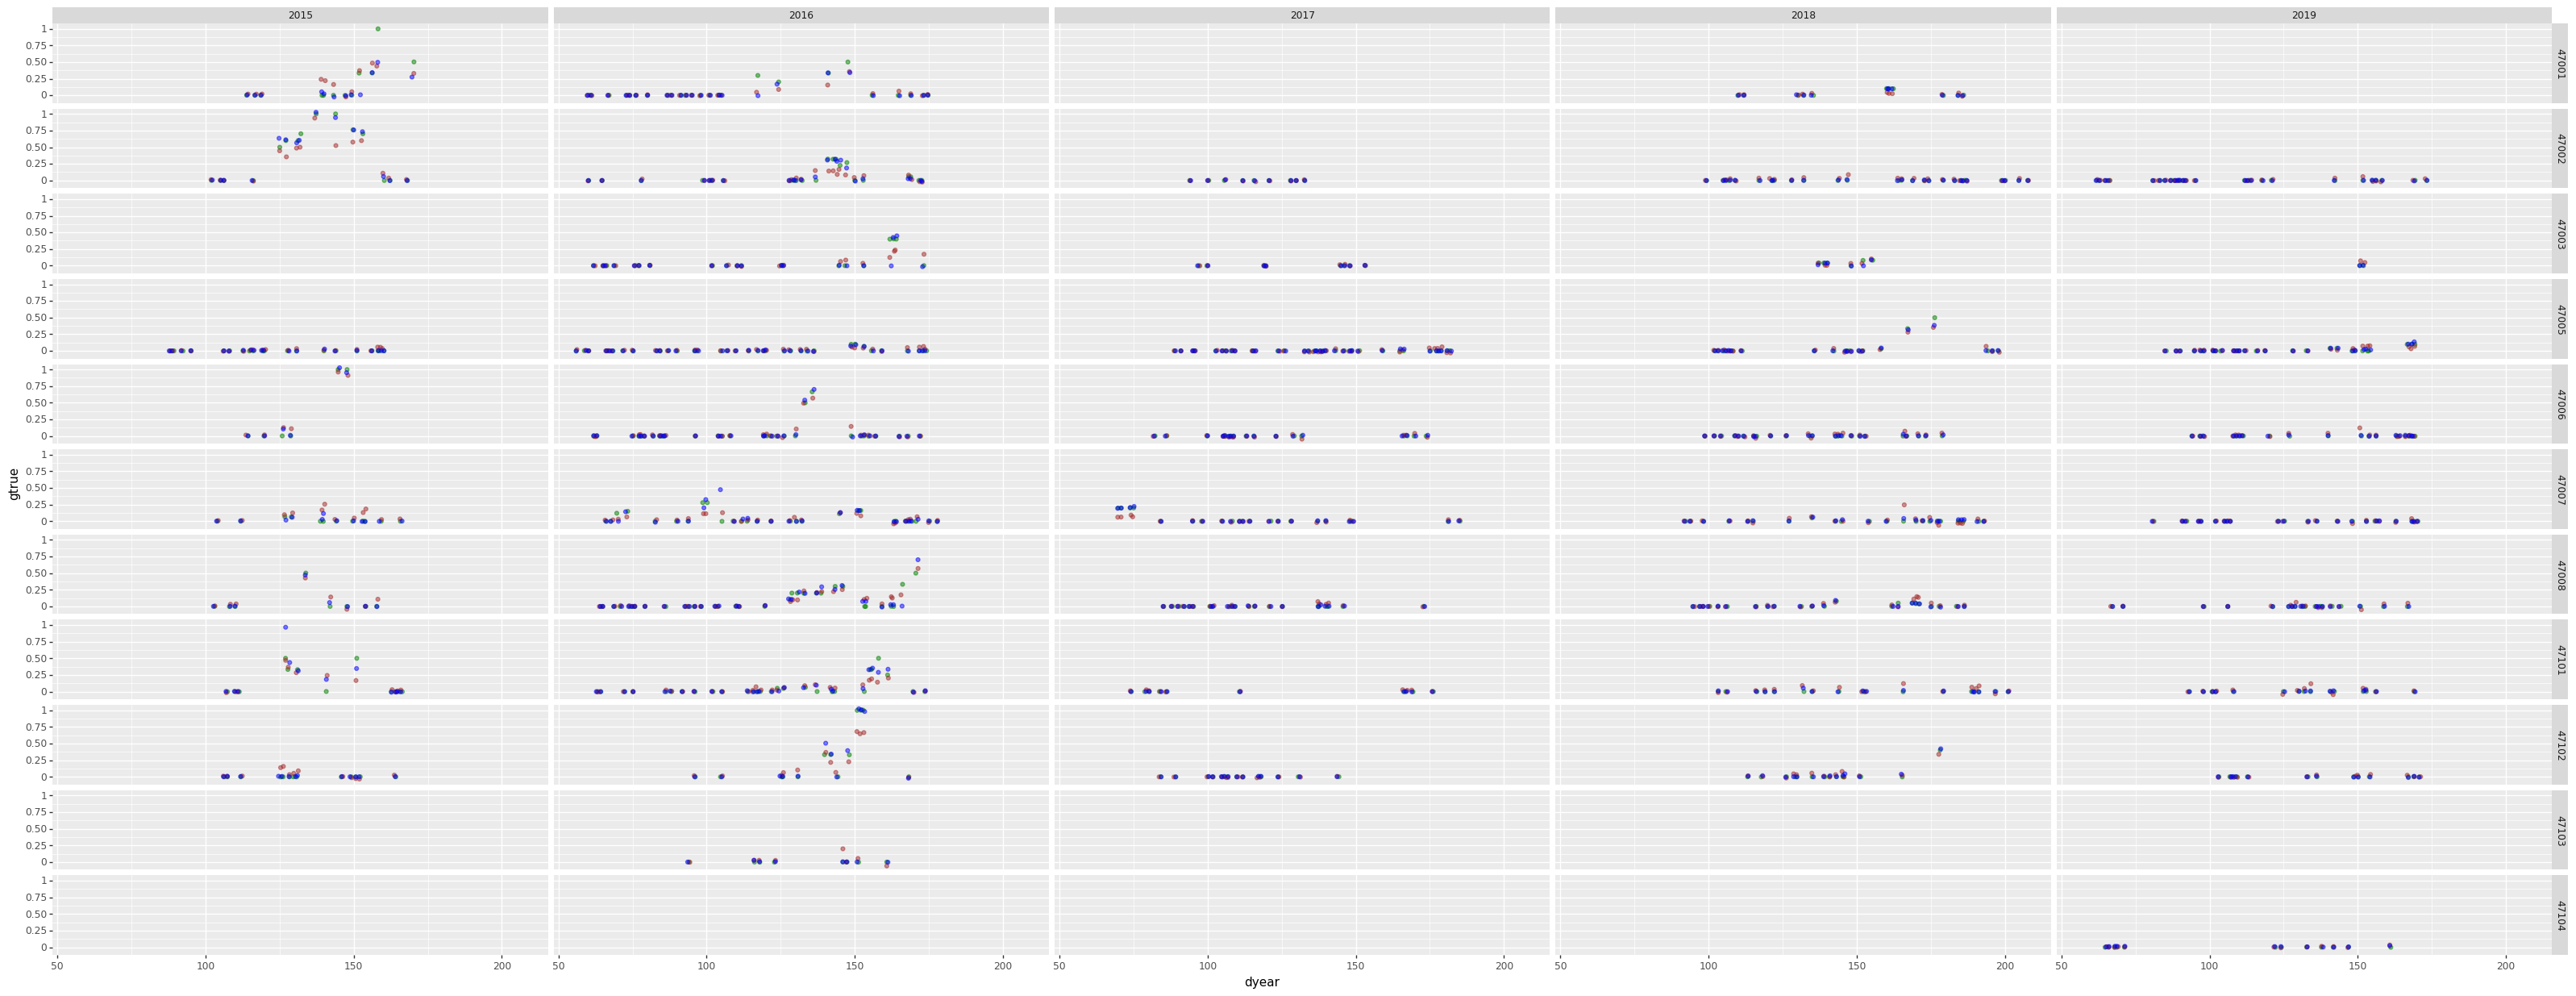

<ggplot: (-9223363245190381785)>
Provincia 37


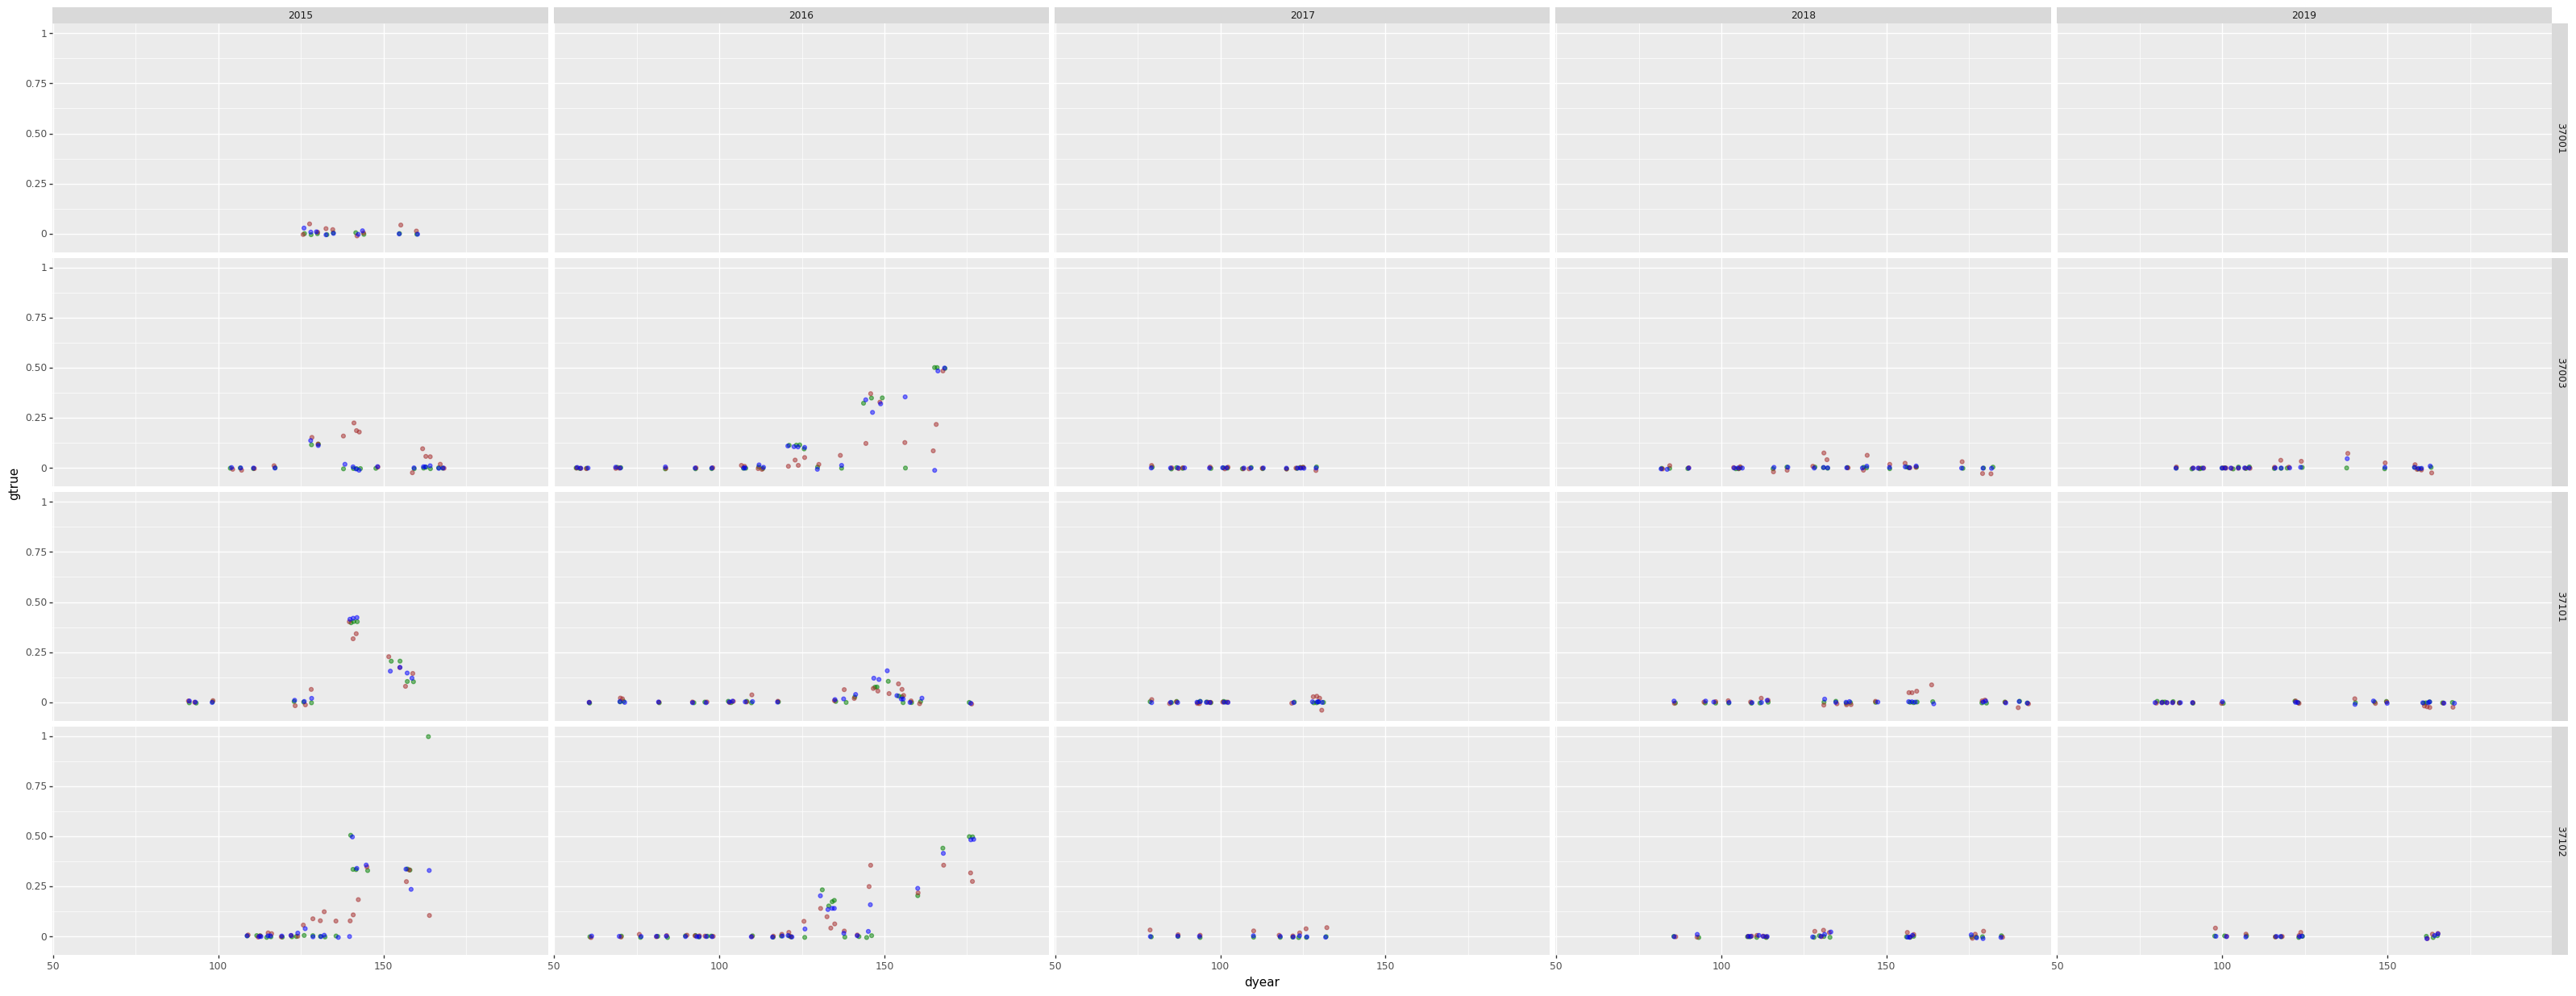

<ggplot: (-9223363245283524720)>
Provincia 42


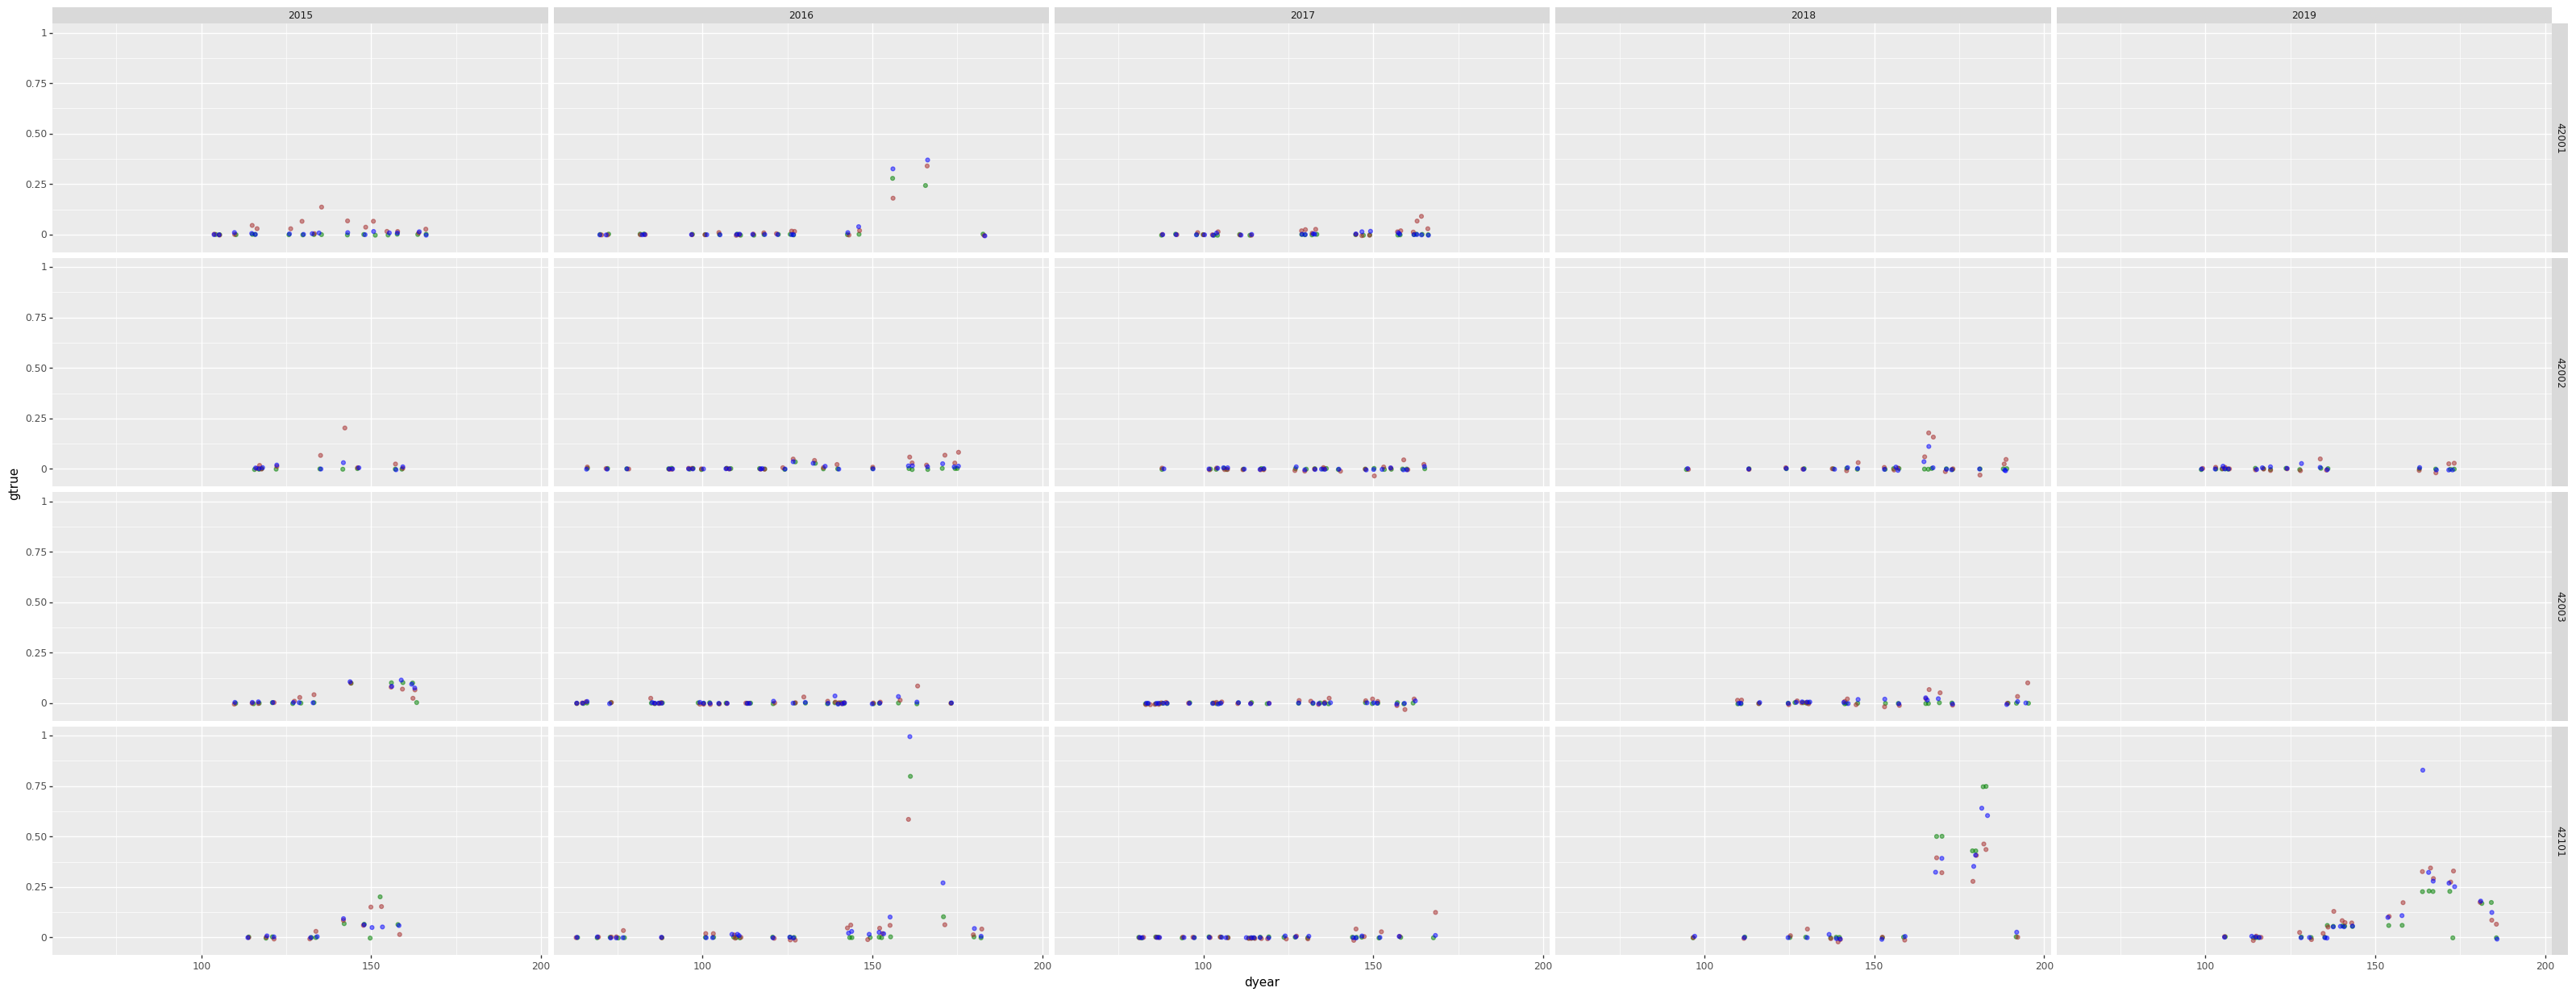

<ggplot: (8791636569334)>
Provincia 09


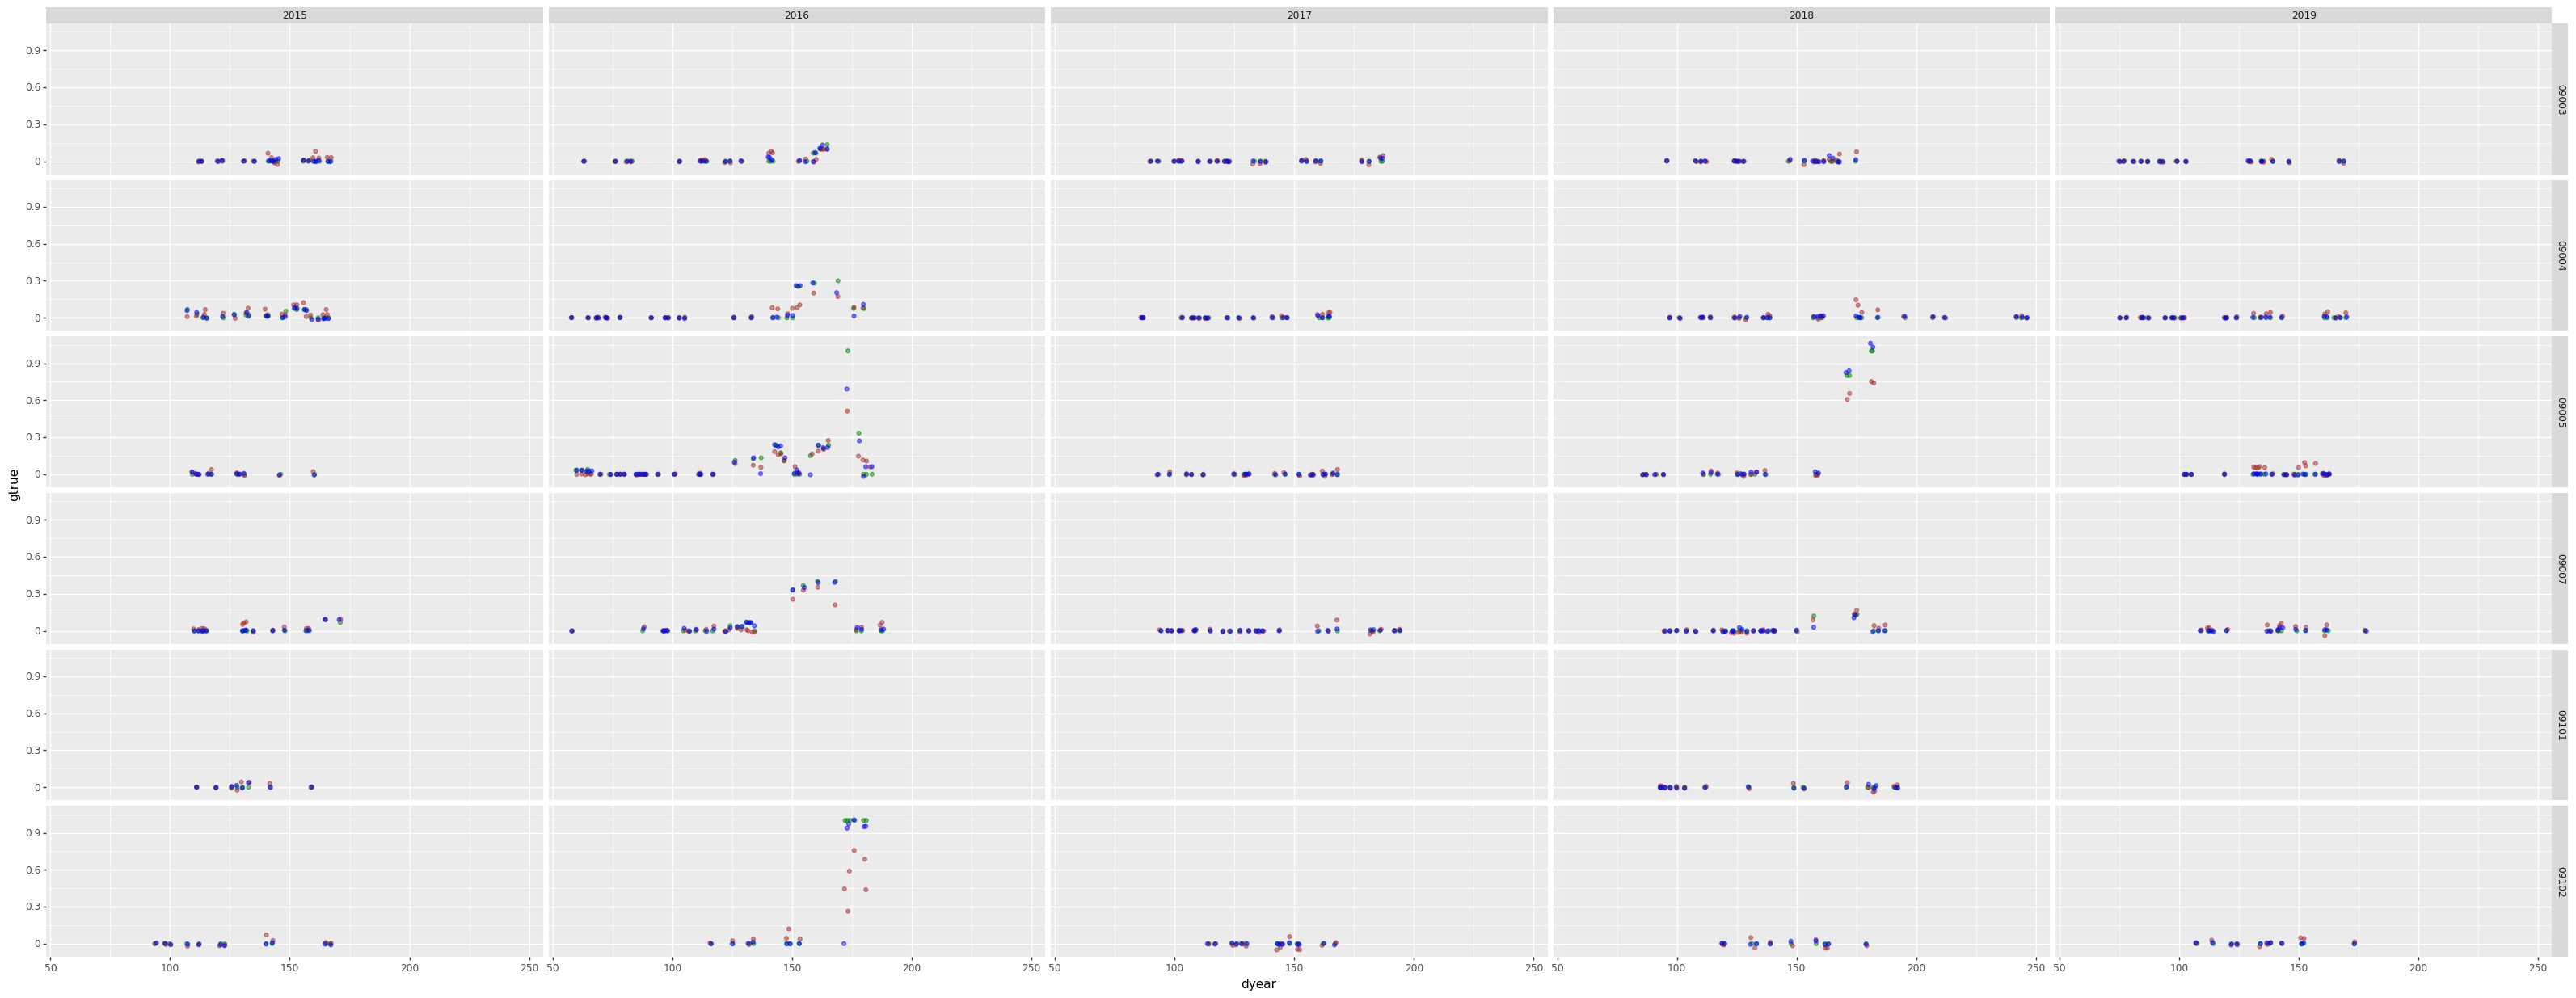

<ggplot: (-9223363245278276941)>
Provincia 05


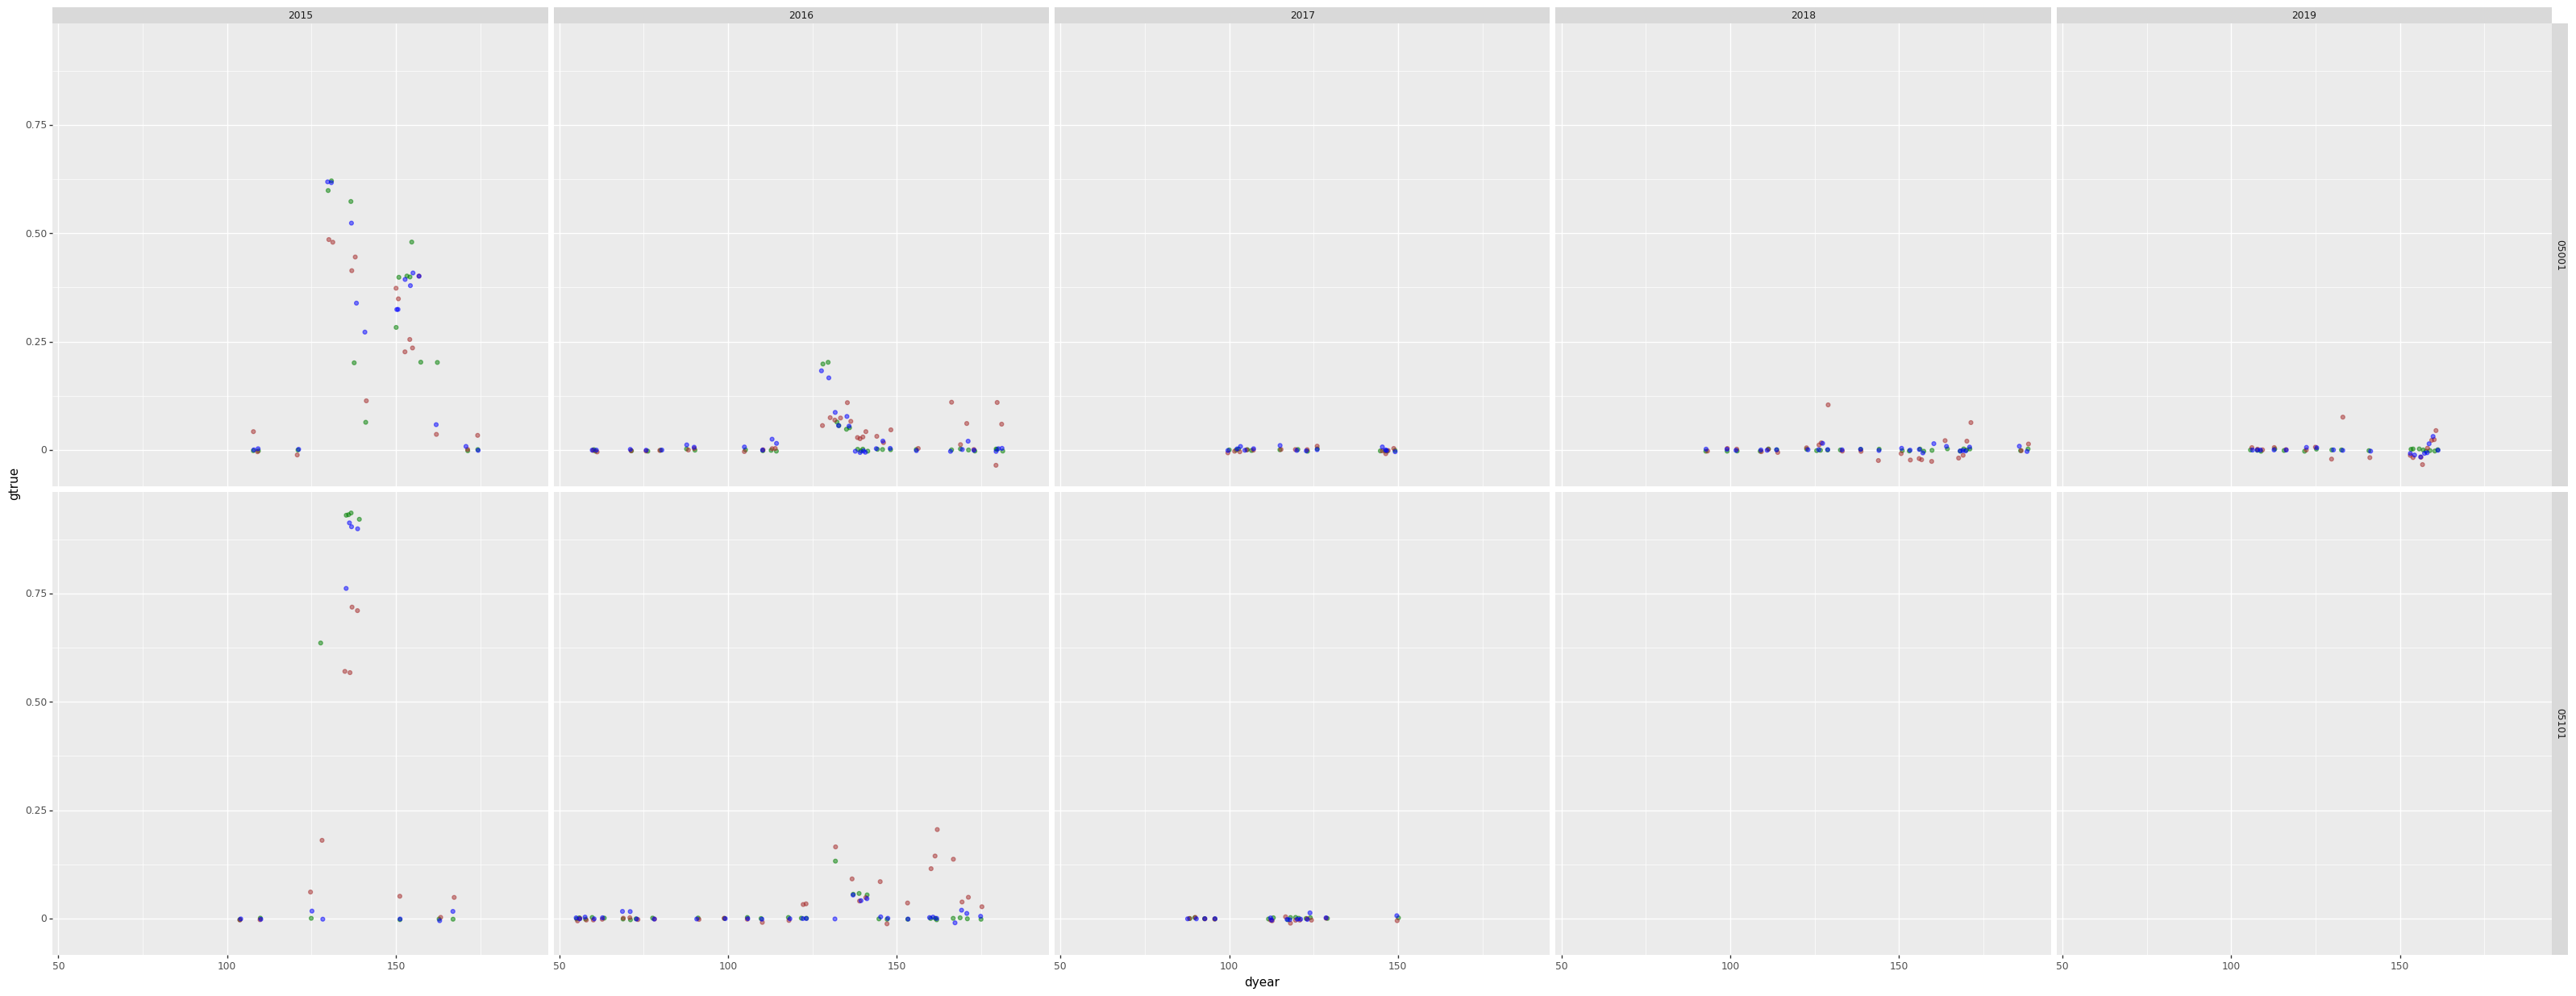

<ggplot: (8791617800382)>
Provincia 40


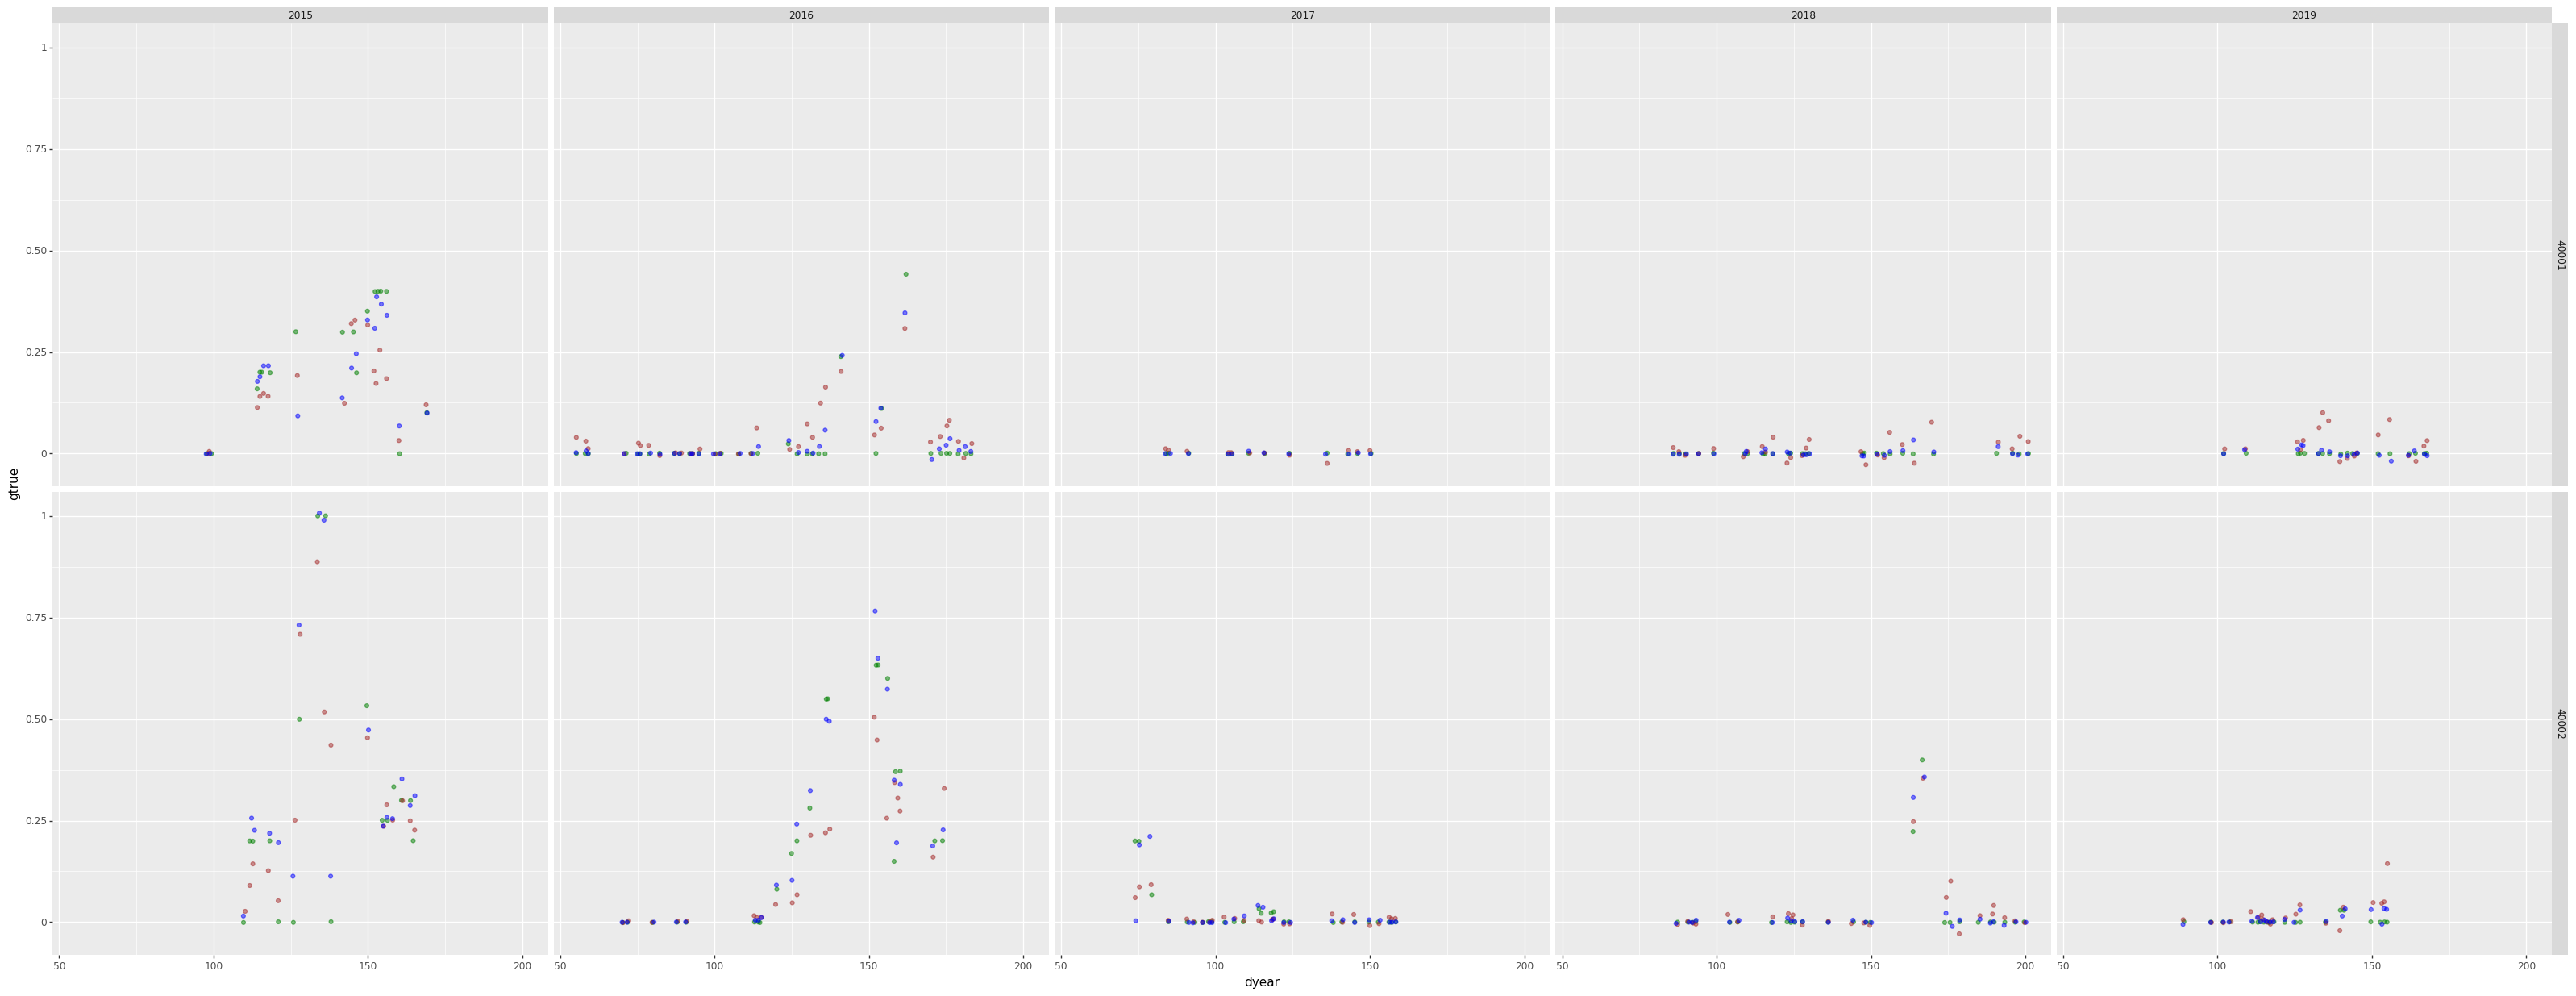

<ggplot: (-9223363245236560447)>


In [63]:
# plt.figure(figsize=(20,30), dpi= 100, facecolor='w', edgecolor='k')
# pltn.options.figure_size = (40, 10)

provinces = ['34', '49', '24', '47', '37', '42', '09', '05', '40']
for prov in provinces:
    print ("Provincia {}".format(prov))
    p=(ggplot(X_test[X_test["prov"] == prov])
        +aes(x='dyear')
        +geom_jitter(aes(y='gtrue'),color="green", size = 1.5, alpha=0.5)
        +geom_jitter(aes(y='pred_xgb'),color='brown', alpha=0.5)
        +geom_jitter(aes(y='pred_xgb-AutoR'),color='blue', alpha=0.5)
        +facet_grid("idest~ year")
         +theme(figure_size=(40, 15))
    #  +theme_matplotlib(rc={"figure.figsize": "20, 20"})
    )    
    print(p)
 


### Residuos por provincia y año (real vs predicción)

**Predicción vs real para conjunto completo de datos (Test y validación)**

Conjunto de test


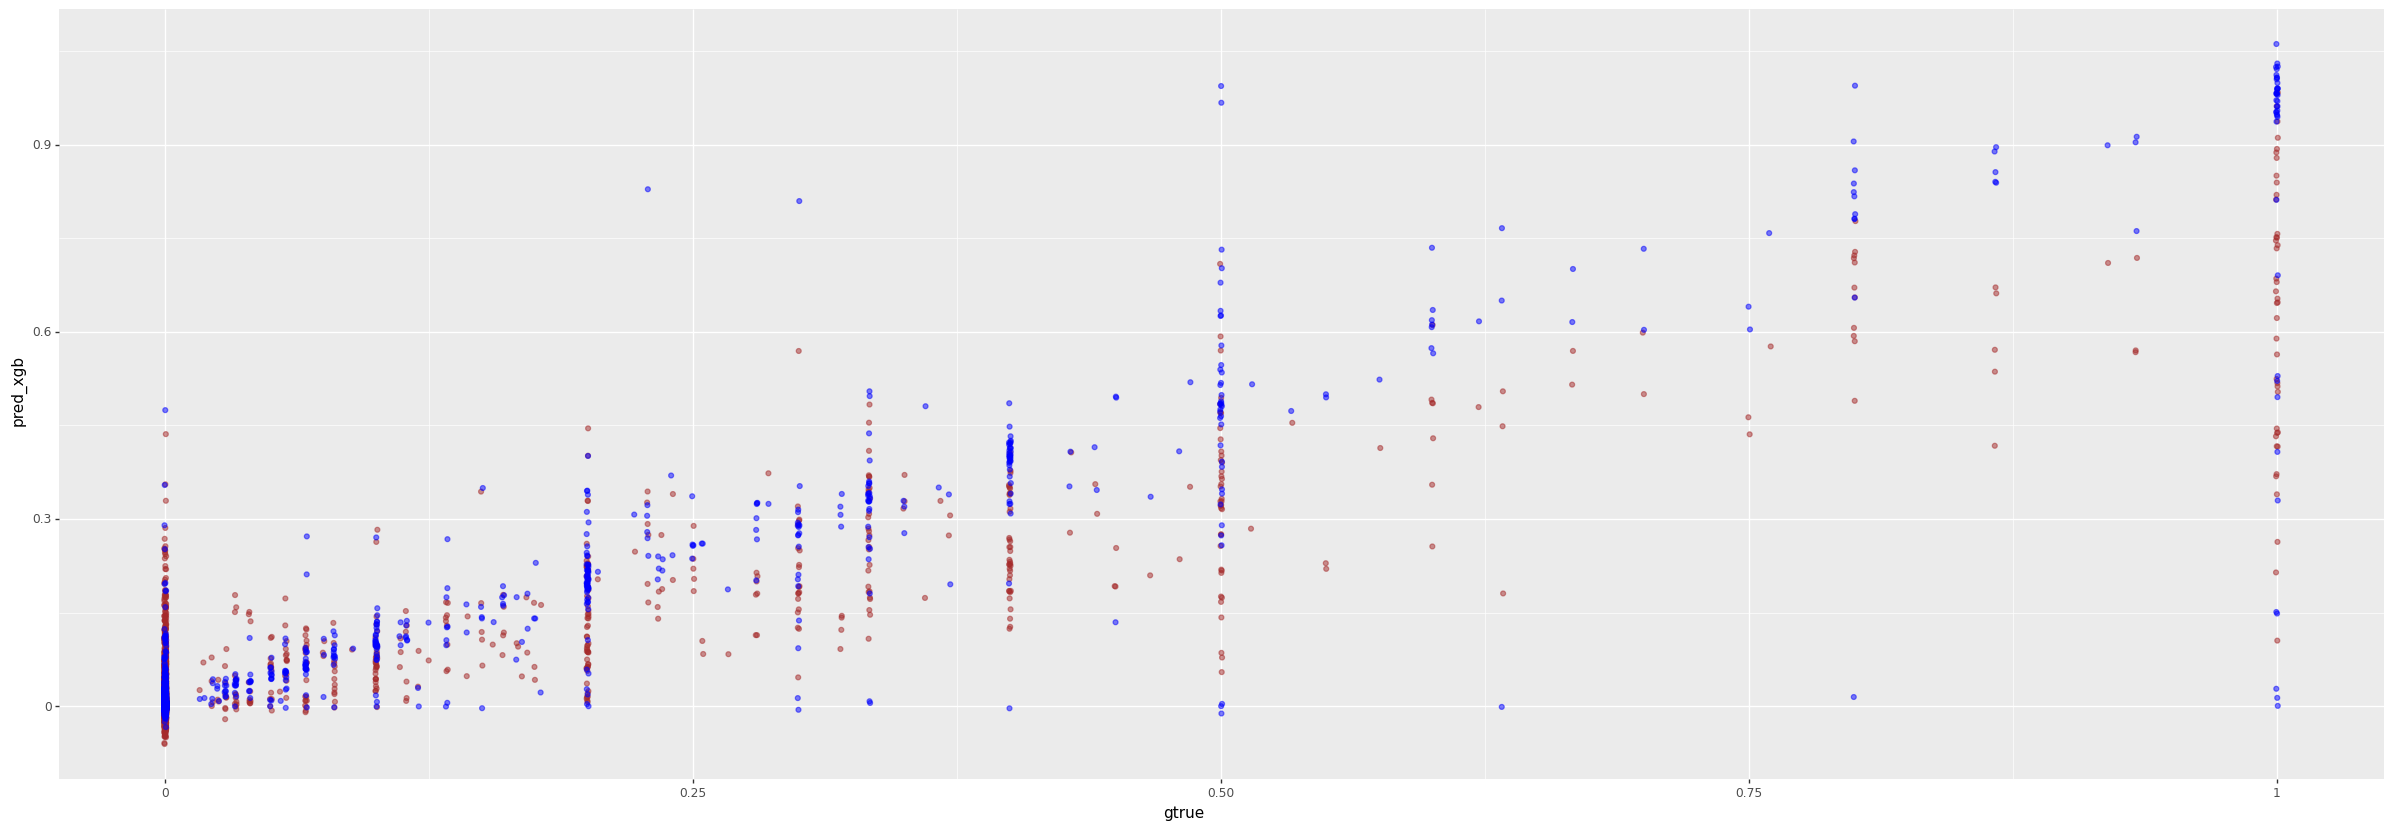

<ggplot: (8791575964252)>
Conjunto de validación


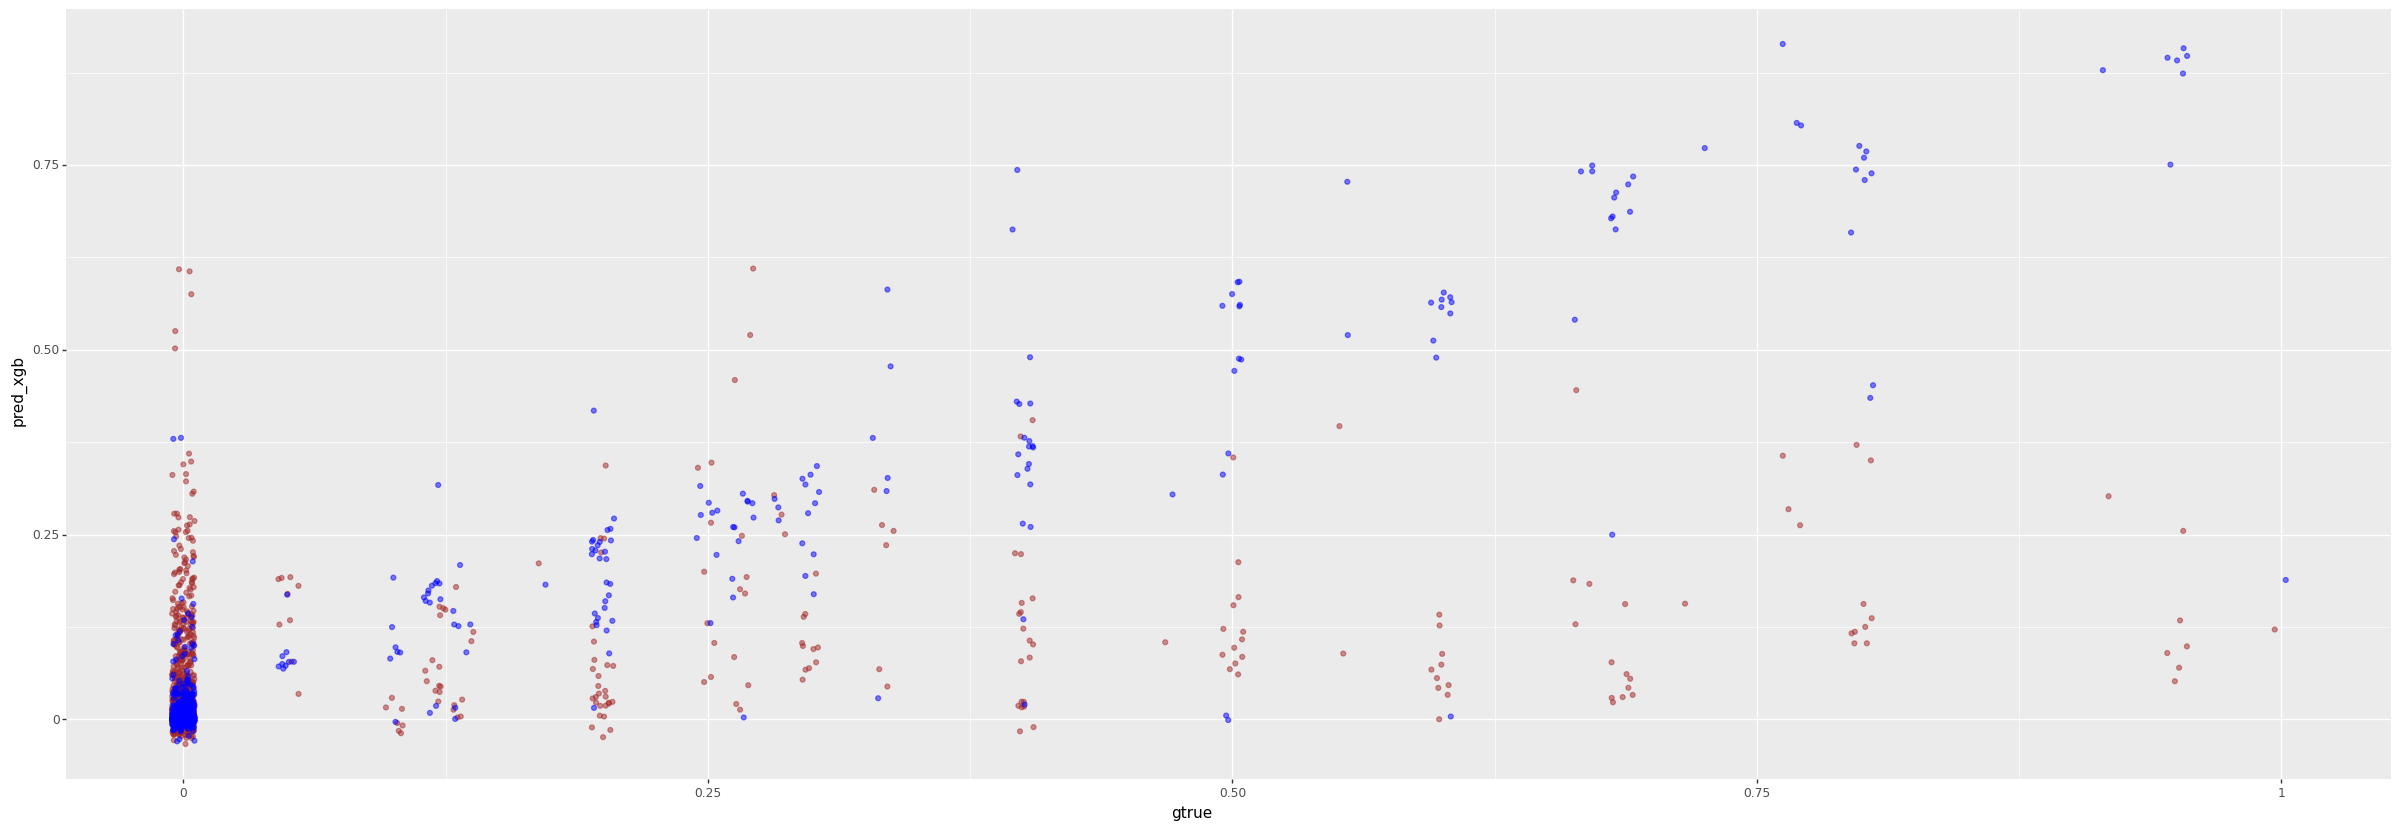

<ggplot: (8791617884522)>


In [75]:
print("Conjunto de test")
print(
    ggplot(X_test)
    +aes(x='gtrue')
    +geom_jitter(aes(y='pred_xgb'),color='brown', alpha=0.5)
    +geom_jitter(aes(y='pred_xgb-AutoR'),color='blue', alpha=0.5)
#     +theme(figure_size=(10, 10))
)
print("Conjunto de validación")
print(
    ggplot(X_val)
    +aes(x='gtrue')
    +geom_jitter(aes(y='pred_xgb'),color='brown', alpha=0.5)
    +geom_jitter(aes(y='pred_xgb-AutoR'),color='blue', alpha=0.5)
#     +theme(figure_size=(10, 10))
)


Provincia 34


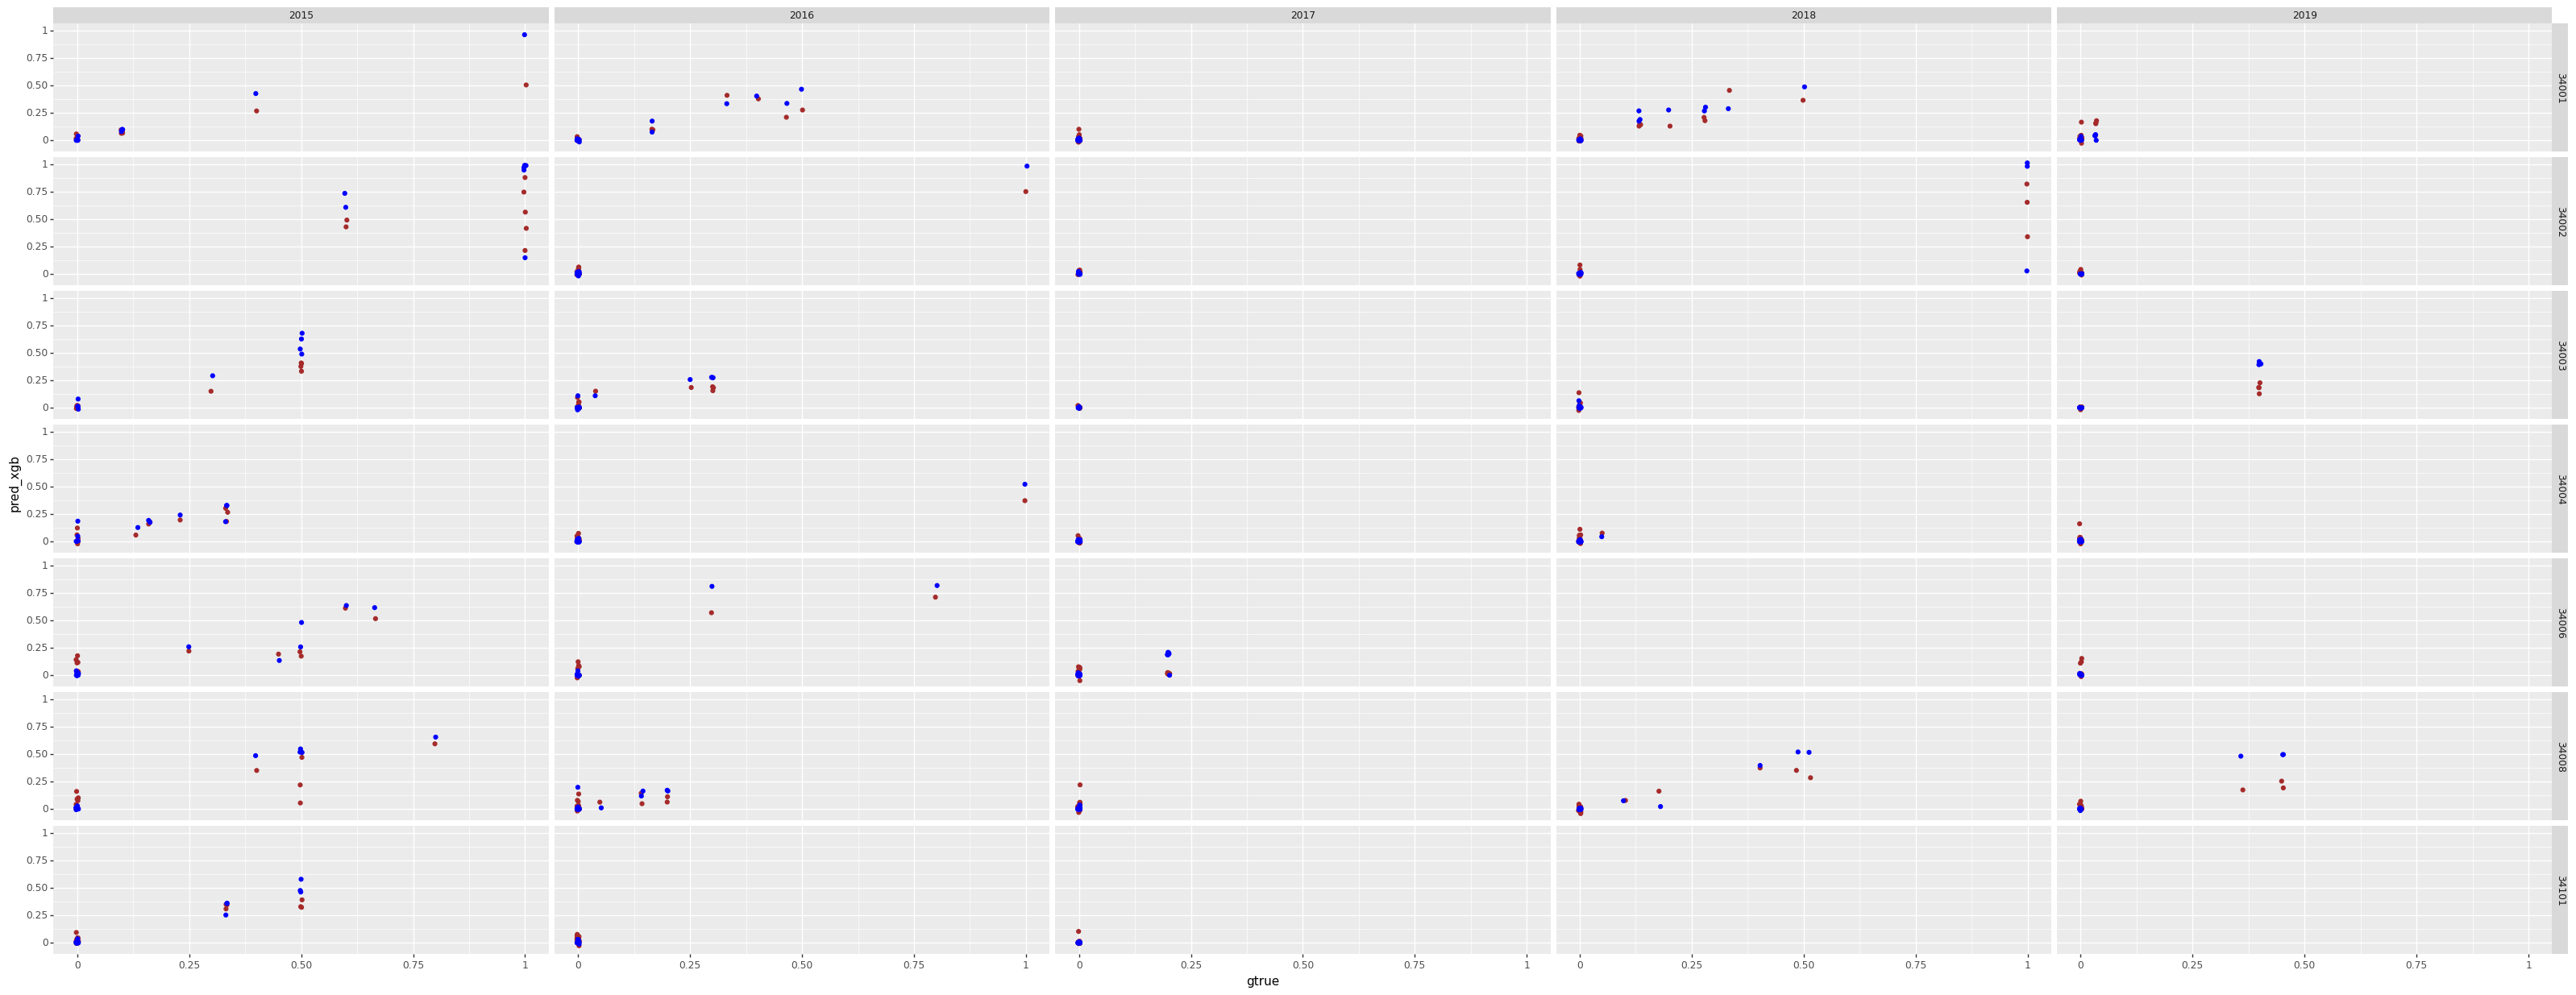

<ggplot: (-9223363245283640253)>
Provincia 49


<ggplot: (-9223363245278309067)>
Provincia 24


<ggplot: (8791617800319)>
Provincia 47


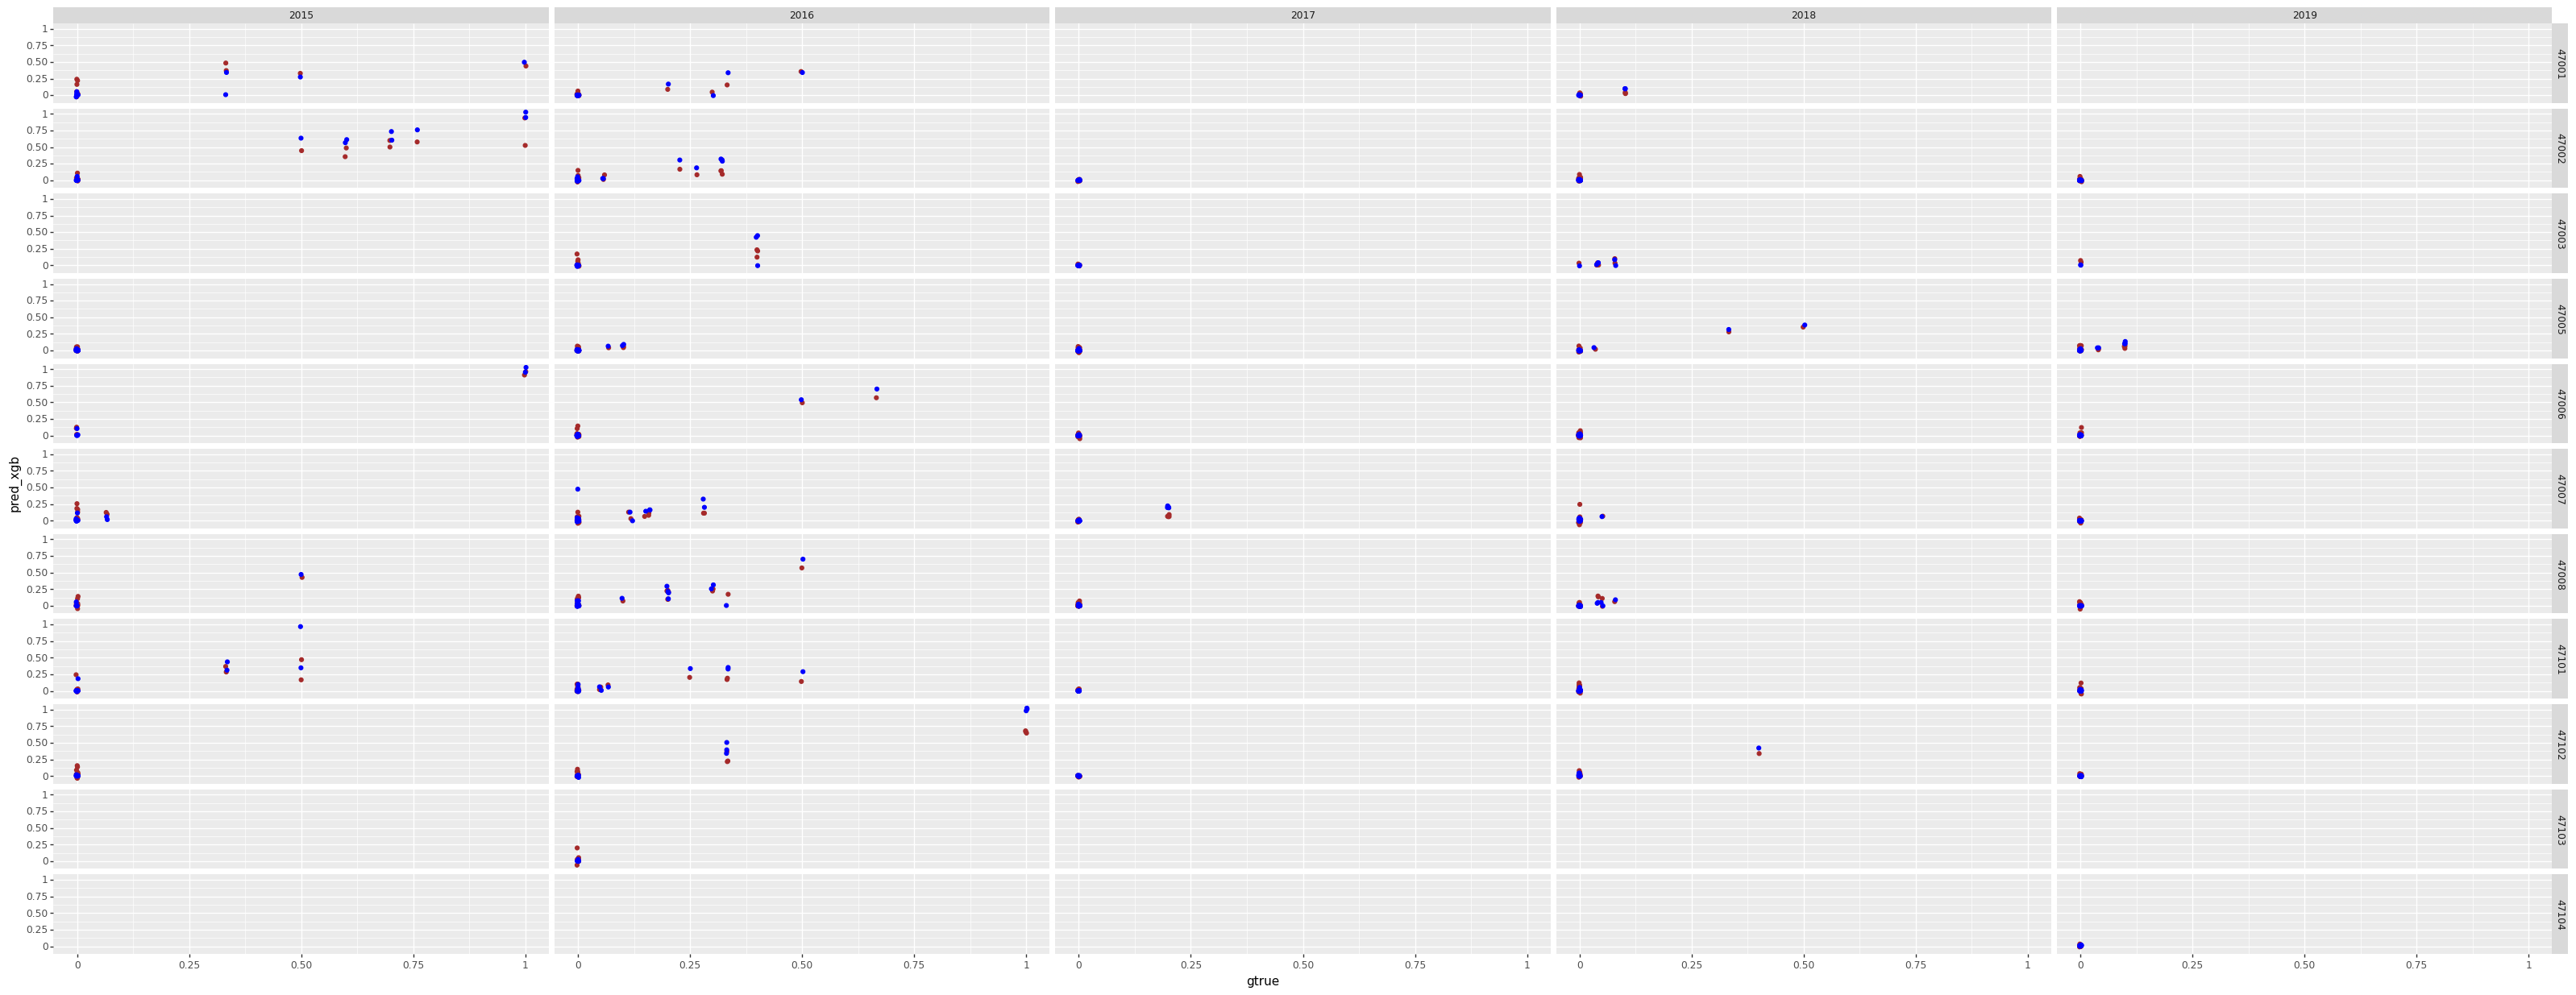

<ggplot: (8791601173291)>
Provincia 37


<ggplot: (8791571266852)>
Provincia 42


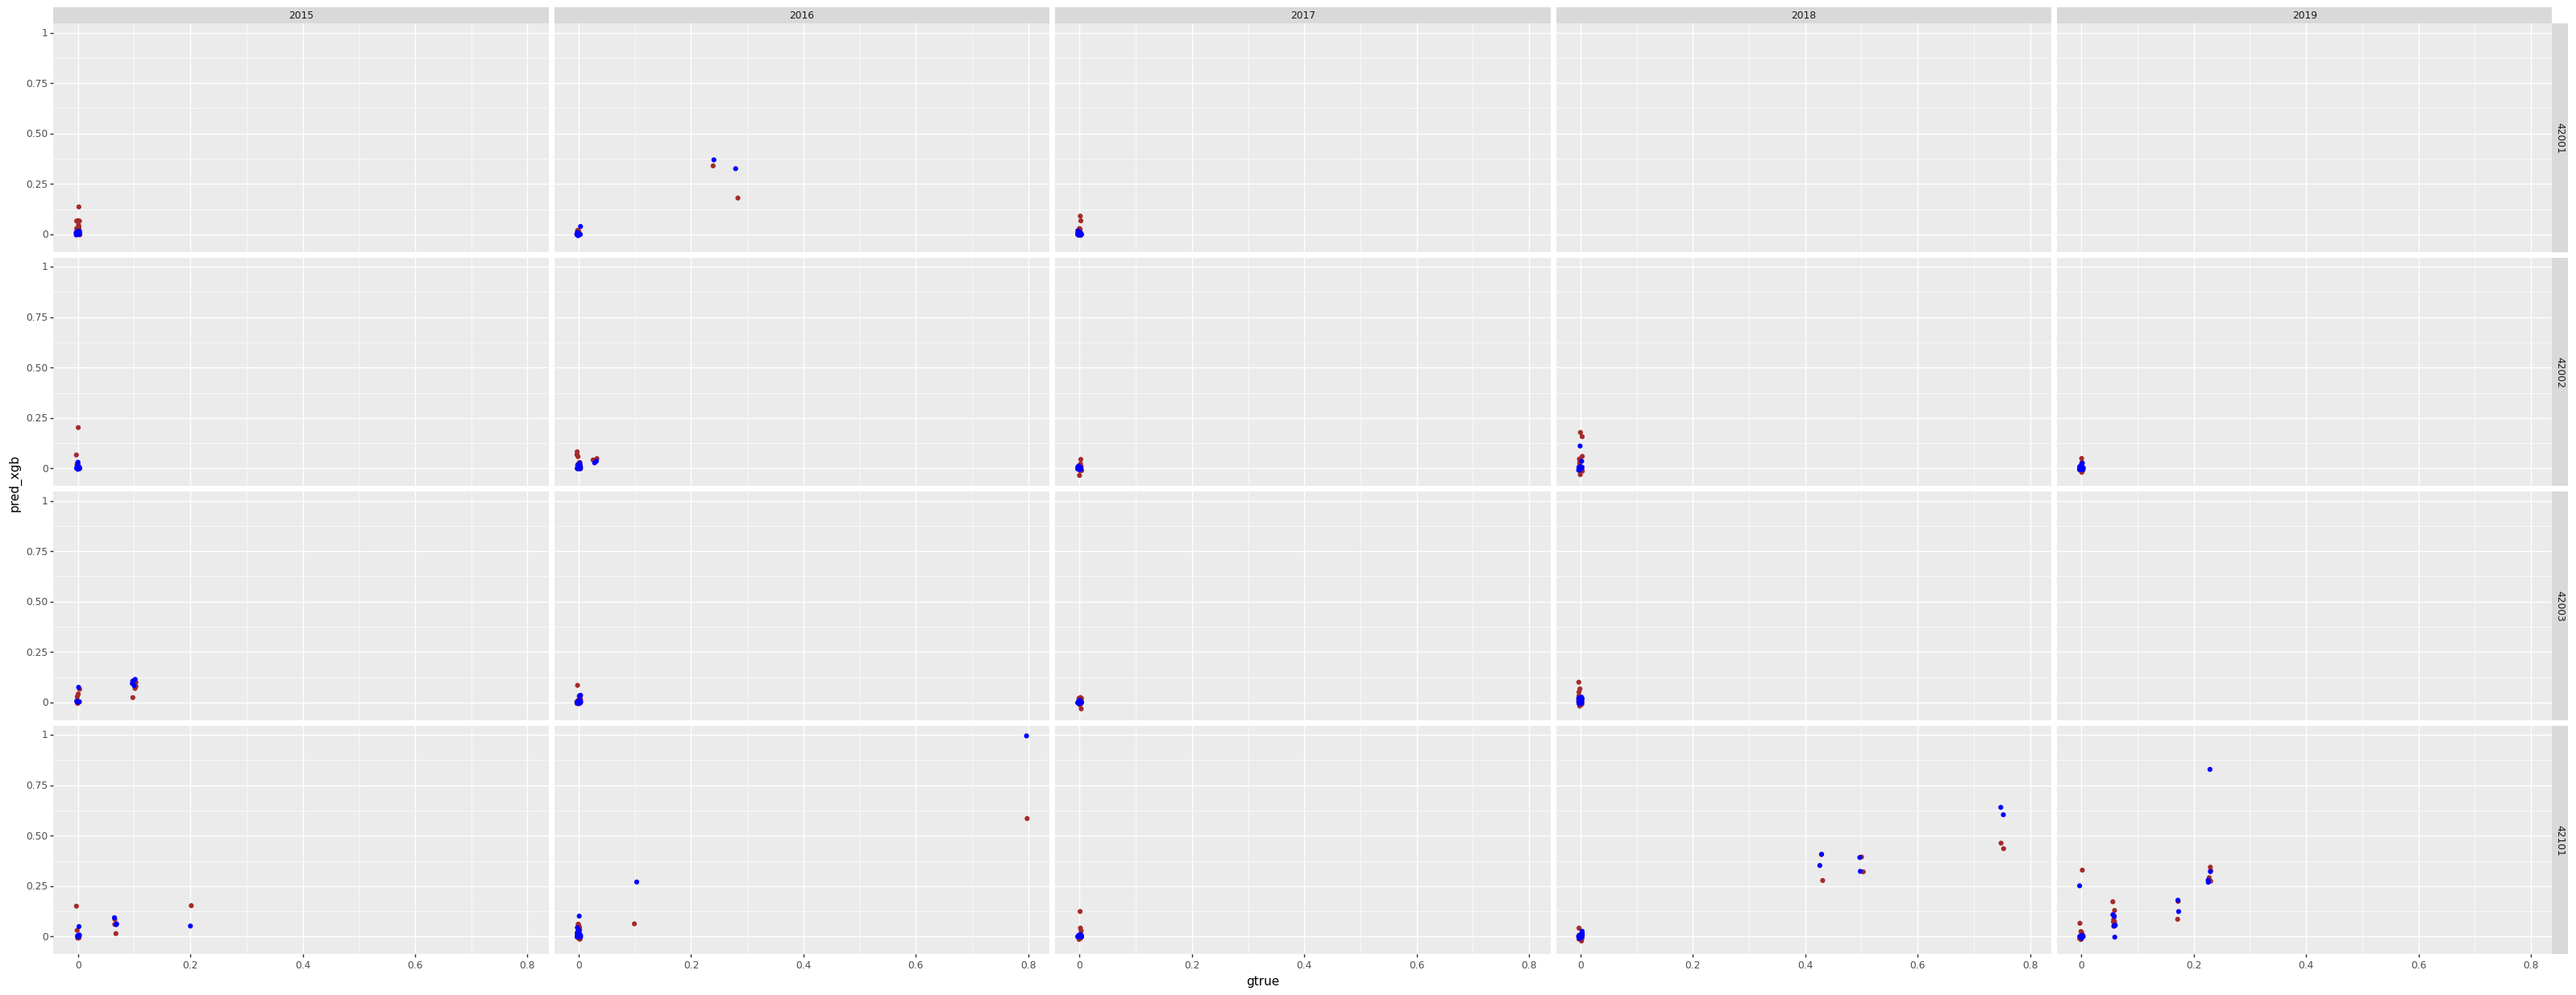

<ggplot: (8791571251078)>
Provincia 09


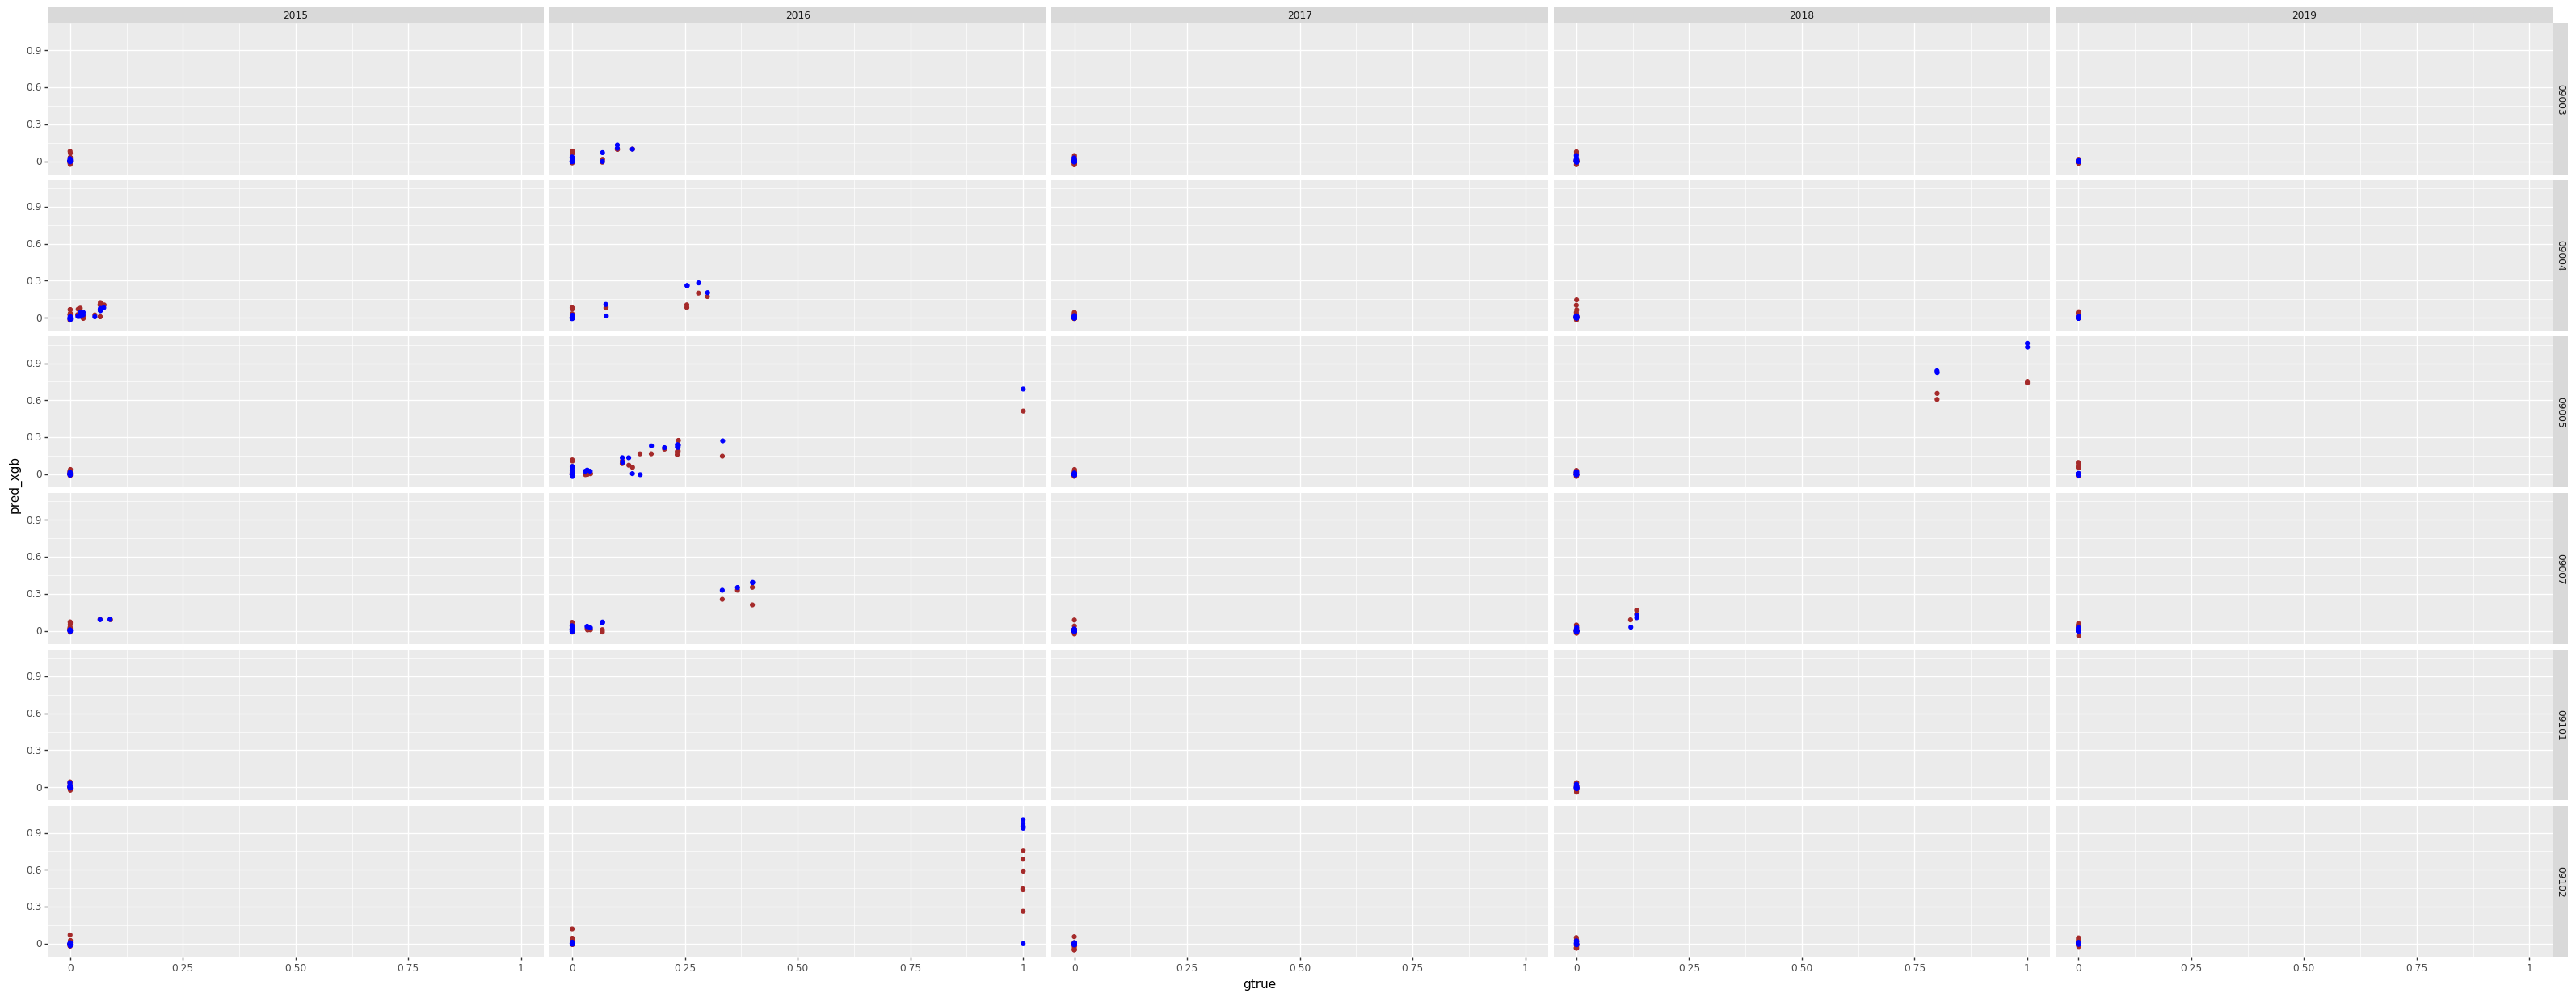

<ggplot: (8791576278420)>
Provincia 05


<ggplot: (8791571267164)>
Provincia 40


<ggplot: (8791571212815)>


In [64]:
# plt.figure(figsize=(20,30), dpi= 100, facecolor='w', edgecolor='k')
# pltn.options.figure_size = (40, 10)

provinces = ['34', '49', '24', '47', '37', '42', '09', '05', '40']
for prov in provinces:
    print ("Provincia {}".format(prov))
    p=(ggplot(X_test[X_test["prov"] == prov])
        +aes(x='gtrue')
        +geom_jitter(aes(y='pred_xgb'),color='brown', alpha=0.5)
        +geom_jitter(aes(y='pred_xgb-AutoR'),color='blue', alpha=0.5)
        +facet_grid("idest~ year")
         +theme(figure_size=(40, 15))
    #  +theme_matplotlib(rc={"figure.figsize": "20, 20"})
    )    
    print(p)
 

# Predicciones 2020

In [84]:
cols = ['temp_min', 'temp_max', 'temp_mean', 'temp_median', 'temp_std',
                      'prec_min', 'prec_max', 'prec_mean', 'prec_median', 'prec_std',
                      'hum_min', 'hum_max', 'hum_mean', 'hum_median', 'hum_std',
                      # 'wdir_min', 'wdir_max', 'wdir_mean', 'wdir_median', 'wdir_std',
                      'wspeed_min', 'wspeed_max', 'wspeed_mean', 'wspeed_median', 'wspeed_std',
                      'radiation_min', 'radiation_max', 'radiation_mean', 'radiation_median', 'radiation_std',
                      'prec_10d', 'prec_30d', 'prec_60d',
                      'temp_int_4_30',
                      'roya_event_skip_10d',  # 'roya_event_10d',
                      'prec_expected_30d', 'prec_exp_perc_30d',  # 'prec_exp_sgm_30d',
                      'prec_expected_60d', 'prec_exp_perc_60d',  # 'prec_exp_sgm_60d',
                      'dyear_sin', 'dyear_cos',
                      'roya_perc_event_skip_10d',
                      'altitud',
                      # 'perc_detected_10d_t1', 'perc_detected_10d_t3', 'perc_detected_10d_t10'
                      ]

# cargar dataset 2020
df = pd.read_parquet('/media/data/climate/inforiego_2014-2020_daily.pkt')
df["dyear"] = df["date"].dt.dayofyear
df['dyear_sin'] = np.sin(2 * np.pi * df['dyear'] / 365)
df['dyear_cos'] = np.cos(2 * np.pi * df['dyear'] / 365)
df["roya_perc_event_skip_10d"] = df['roya_event_skip_10d'] / (10 * 24 * 2)
df["roya_perc_event_10d"] = df['roya_event_10d'] / (10 * 24 * 2)

df.columns

Index(['idest', 'date', 'temp_min', 'temp_max', 'temp_mean', 'temp_median',
       'temp_std', 'prec_min', 'prec_max', 'prec_mean', 'prec_median',
       'prec_std', 'hum_min', 'hum_max', 'hum_mean', 'hum_median', 'hum_std',
       'wdir_min', 'wdir_max', 'wdir_mean', 'wdir_median', 'wdir_std',
       'wspeed_min', 'wspeed_max', 'wspeed_mean', 'wspeed_median',
       'wspeed_std', 'radiation_min', 'radiation_max', 'radiation_mean',
       'radiation_median', 'radiation_std', 'prec_10d', 'prec_30d', 'prec_60d',
       'temp_int_4_30', 'prec_expected_30d', 'prec_expected_60d',
       'roya_event_10d', 'roya_event_skip_10d', 'prec_exp_perc_30d',
       'prec_exp_perc_60d', 'prec_exp_sgm_30d', 'prec_exp_sgm_60d', 'dyear',
       'dyear_sin', 'dyear_cos', 'roya_perc_event_skip_10d',
       'roya_perc_event_10d'],
      dtype='object')